# Deep Learning Project Work  
<a href="https://www.kaggle.com/code/miklosgergely/deep-learning-hw-milestone-1-d45557?scriptVersionId=113550262">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Source material:
- https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac
- https://www.kaggle.com/code/danieldelro/unsupervised-anomaly-segmentation-of-screw-images 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torchvision import models
import math

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# Downloading data from the MVTecAD database - Carpet and Hazelnut categories were used

!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz
!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz
!tar -xf hazelnut.tar.xz 
!tar -xf carpet.tar.xz

--2022-12-11 20:31:49--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 617098680 (589M) [application/x-xz]
Saving to: ‘hazelnut.tar.xz’

hazelnut.tar.xz     100%[===================>] 588.51M  23.0MB/s    in 27s     

2022-12-11 20:32:16 (22.0 MB/s) - ‘hazelnut.tar.xz’ saved [617098680/617098680]

--2022-12-11 20:32:16--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740285760 (706M) [application/x-xz]
Saving to: ‘carpet.tar.xz’

carpet.tar.xz       100%[===================

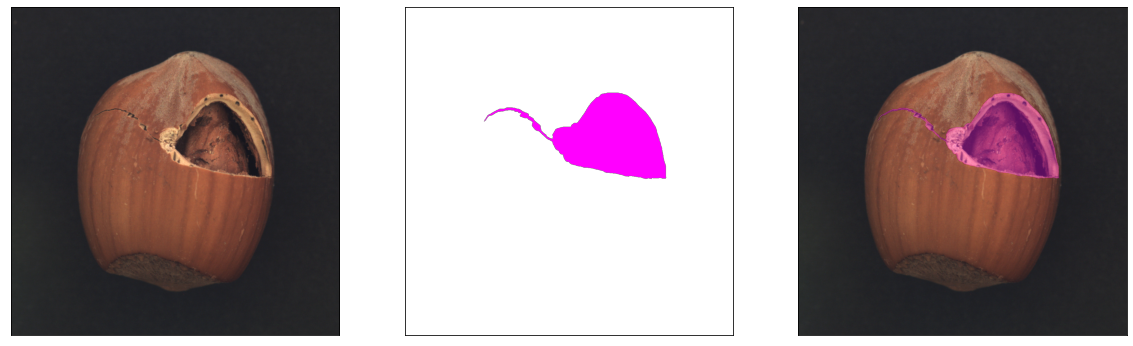

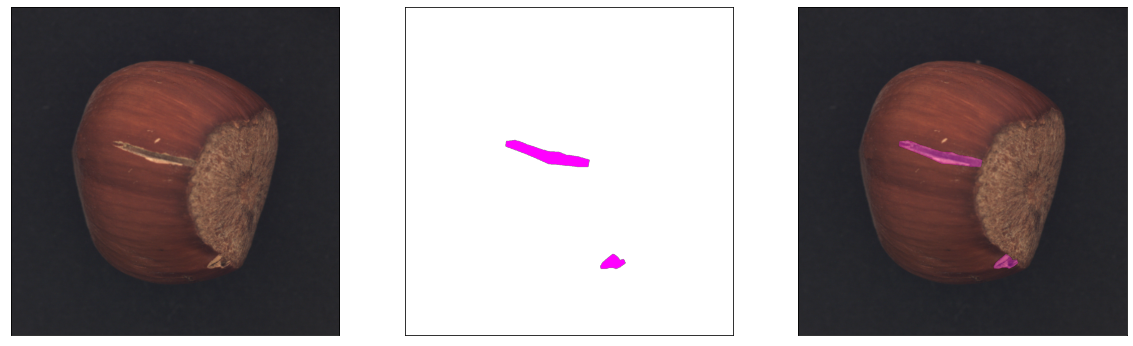

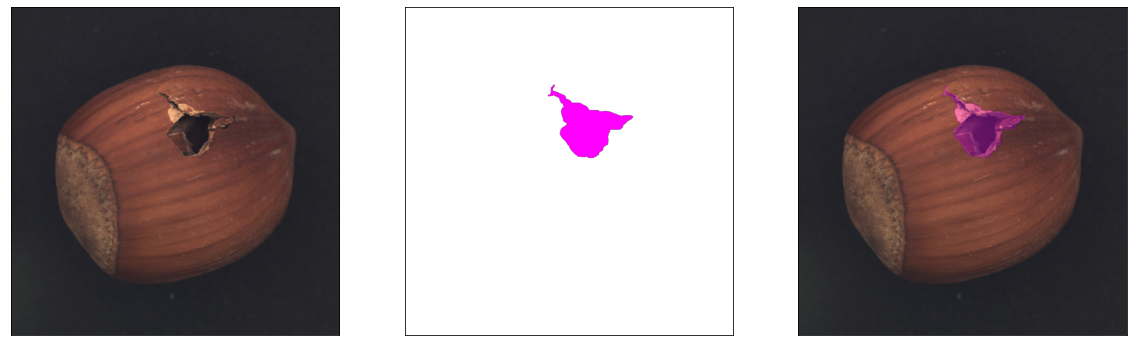

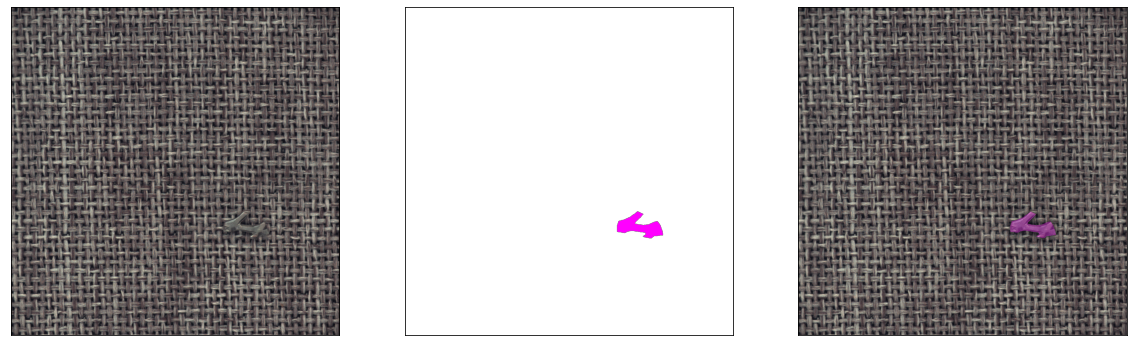

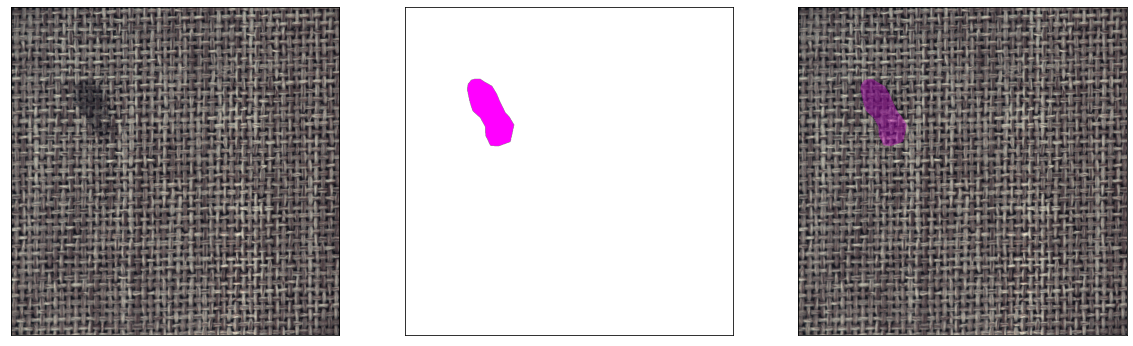

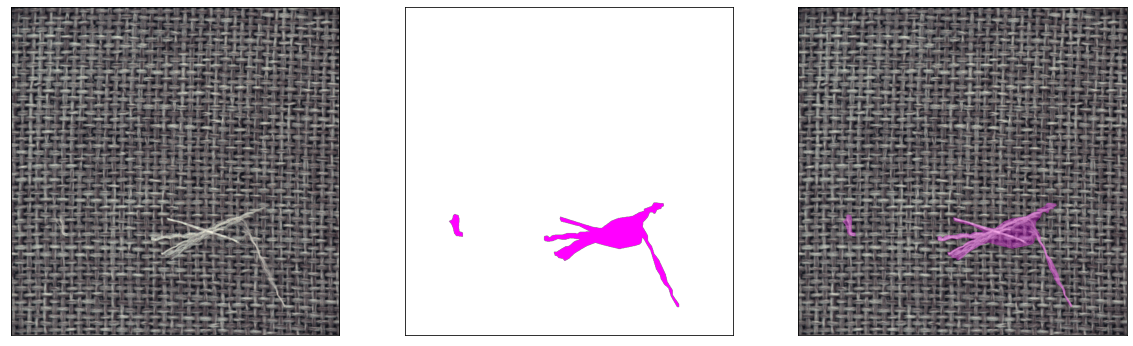

In [3]:
def test_image_visualization():

  image_paths = ['./hazelnut/test/crack/000.png','./hazelnut/test/cut/006.png',
                 './hazelnut//test/hole/013.png','./carpet/test/metal_contamination/004.png',
                 './carpet/test/color/005.png', './carpet/test/thread/008.png']
  mask_paths = ['./hazelnut/ground_truth/crack/000_mask.png','./hazelnut/ground_truth/cut/006_mask.png',
                './hazelnut/ground_truth/hole/013_mask.png','./carpet/ground_truth/metal_contamination/004_mask.png',
                './carpet/ground_truth/color/005_mask.png', './carpet/ground_truth/thread/008_mask.png']

  for i in range(0,len(image_paths)):

    msk = cv2.imread(str(mask_paths[i]))
    img = cv2.imread(str(image_paths[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    n_msk = mask_color_magenta(msk)
    plot_images(img, n_msk)
    
    
    
def plot_images(img, n_msk):

  plt.figure(figsize = (20,20))

  plt.subplot(131)
  plt.imshow(img)
  plt.xticks([]), plt.yticks([])

  plt.subplot(132)
  plt.imshow(n_msk)
  plt.xticks([]), plt.yticks([])

  plt.subplot(133)
  plt.imshow(img)
  plt.imshow(n_msk, alpha = 0.3)
  plt.xticks([]), plt.yticks([])
  
  plt.show()



def mask_color_magenta(img):
  # Modifies the original mask image - makes background transparent + sets the 
  # color of the segmented parts to magenta

  # separate R,G,B color channels and create a mask for the white pixels of the image
  mask = (img[:,:,0] == 255) & (img[:,:,1] == 255) & (img[:,:,2] == 255)
  # set the new color for white coloured pixels
  img[:,:,:3][mask] = [255,0,255] 
  # convert image to grayscale and "create a dimension for opacity"
  tmp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
  # split image by color channels and append 4th 'opacity' dimension
  b, g, r = cv2.split(img)
  rgba = [b, g, r, alpha]
  n_img = cv2.merge(rgba, 4)

  return n_img

test_image_visualization()

# Model section

Our model is a pretty simple autoencoder architecture with extra added convolutional layers. This convolutional section helps us better deal with image data. We have to keep the autoencoder architecture in mind, when designing the convolutional section, because in a way that the encoder's reverse is the decoder, this way our convolutional section has to have a deconvolutional section as well, which basically means using transposed convolutional layers.

In [4]:
import torch.nn as nn

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [5]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

lr= 0.0007

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
## Latent dimension
d = 5

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

### Define an optimizer (both for the encoder and the decoder!)
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)

Selected device: cpu


Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [6]:
decoder.to(device)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# Dataset and Dataloader creation

In [7]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(28),
#                                 torchvision.transforms.RandomCrop(28),    
#                                 torchvision.transforms.RandomHorizontalFlip(),
#                                 torchvision.transforms.RandomVerticalFlip(),
                                torchvision.transforms.ToTensor(),
                               ])

hazelnut_train_dataset = torchvision.datasets.ImageFolder("./hazelnut/train/",transform=transform)
hazelnut_test_dataset = torchvision.datasets.ImageFolder("./hazelnut/test/",transform=transform)

carpet_train_dataset = torchvision.datasets.ImageFolder("./carpet/train/",transform=transform)
carpet_test_dataset = torchvision.datasets.ImageFolder("./carpet/test/",transform=transform)

hazelnut_test_length = int(len(hazelnut_test_dataset) * 0.8)
hazelnut_val_length = len(hazelnut_test_dataset) - hazelnut_test_length

carpet_test_length = int(len(carpet_test_dataset) * 0.8)
carpet_val_length = len(carpet_test_dataset) - carpet_test_length

hazelnut_test_dataset, hazelnut_val_dataset = torch.utils.data.random_split(hazelnut_test_dataset,[hazelnut_test_length,hazelnut_val_length],generator=torch.Generator().manual_seed(42))
carpet_test_dataset, carpet_val_dataset = torch.utils.data.random_split(carpet_test_dataset,[carpet_test_length,carpet_val_length],generator=torch.Generator().manual_seed(42))


hazelnut_train_loader  = torch.utils.data.DataLoader(hazelnut_train_dataset,batch_size=32,shuffle=True)
hazelnut_test_loader  = torch.utils.data.DataLoader(hazelnut_test_dataset,batch_size=32,shuffle=False)
hazelnut_val_loader  = torch.utils.data.DataLoader(hazelnut_val_dataset,batch_size=32,shuffle=True)
carpet_train_loader  = torch.utils.data.DataLoader(carpet_train_dataset,batch_size=32,shuffle=True)
carpet_test_loader  = torch.utils.data.DataLoader(carpet_test_dataset,batch_size=32,shuffle=False)
carpet_val_loader  = torch.utils.data.DataLoader(carpet_val_dataset,batch_size=32,shuffle=True)

hazelnut_vis_test_loader = torch.utils.data.DataLoader(hazelnut_test_dataset,batch_size=len(hazelnut_test_dataset))
carpet_vis_test_loader = torch.utils.data.DataLoader(carpet_test_dataset,batch_size=len(hazelnut_test_dataset))

# Train, Test, Evaluation, and Visualization functions

In [8]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [9]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [10]:
def plot_ae_outputs(encoder,decoder,vis_test_loader, n=5): # n stands for the number of classes
    plt.figure(figsize=(16,4.5))
    # Get the test images and labels from our loader
    images ,targets = next(iter(vis_test_loader))
    # Group them into a dictionary with keys as possible labels
    t_idx = {i:np.where(targets==i)[0] for i in range(n)}
    # Plot for each class
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      # Get our image from the test dataset
      img = images[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      # Put the test image through our autoencoder
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.T.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.T.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

In [11]:
def compute_threshold(encoder, decoder, dataloader, fpr = 0.05):
    # Compute the error threshold on the trained model with training dataset.
    # The threshold is the q-th percentile of the output pixels' squared errors
    encoder.eval()
    decoder.eval()
    errors = []
    with torch.no_grad():
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)

            rec_img_batch = decoder(encoder(image_batch))

            error_batch = torch.sum((rec_img_batch - image_batch)**2, axis=1).cpu().numpy()
            errors.extend(error_batch)

    threshold = np.percentile(errors, 100-fpr)
    return threshold

In [12]:
def predict(encoder, decoder, dataloader, threshold):
    # Calculates errors on the given dataset and compares it to the computed threshold (error > t.hold -> anomaly)
    # Returns a list of booleans, where each item is true if the model detected an anomaly.
    encoder.eval()
    decoder.eval()
    predictions = []
    with torch.no_grad():
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            
            rec_img_batch = decoder(encoder(image_batch))
            
            error_batch = torch.sum((rec_img_batch - image_batch)**2, axis=1).T.cpu().numpy()
            pred_batch = np.any(error_batch > threshold, axis=(0,1))
            
            predictions.extend(pred_batch)
            
    return predictions

In [13]:
def evaluation(encoder, decoder, dataloader, threshold):
    # Calculates errors on the given (test) dataset and compares it to the computed threshold (error > t.hold -> anomaly)
    # Returns a list of booleans, where each item is true if the prediction is equal to the actual value
    encoder.eval()
    decoder.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for image_batch, label_batch in dataloader:
            image_batch = image_batch.to(device)
            
            rec_img_batch = decoder(encoder(image_batch))
            
            error_batch = torch.sum((rec_img_batch - image_batch)**2, axis=1).cpu().numpy()
            pred_batch = np.any(error_batch > threshold, axis=(1,2))
            
            predictions.extend(pred_batch)
            labels.extend(label_batch.cpu().numpy() != 2)
            
    return predictions, labels

In [14]:
def experimental_evaluation(encoder, decoder, dataset, threshold, n=10):
    # Evaluation wiyh n samples and visualization 
    encoder.eval()
    decoder.eval()
    for i, (img, label) in enumerate(dataset):
        if i == n - 1:
            break
        
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            rec_img = decoder(encoder(img))
        error = torch.sum((rec_img - img)**2, axis=1).T.cpu().squeeze().numpy()
        
        prediction = np.any(error > threshold, axis=(0,1))
        mask = np.where(error > threshold, 255, 0)
        
        _, axarr = plt.subplots(1,2, figsize=(15,15))
        axarr[0].imshow(img.T.cpu().squeeze().numpy(), cmap='gist_gray')
        axarr[1].imshow(img.T.cpu().squeeze().numpy(), cmap='gist_gray')
        axarr[1].imshow(mask, cmap='jet', alpha=0.5, interpolation='none')
        plt.show()

# Training loops

## Training on the hazelnut dataset

	 partial train loss (single batch): 0.116245
	 partial train loss (single batch): 0.114981
	 partial train loss (single batch): 0.112731
	 partial train loss (single batch): 0.111813
	 partial train loss (single batch): 0.111615
	 partial train loss (single batch): 0.108782
	 partial train loss (single batch): 0.106461
	 partial train loss (single batch): 0.103351
	 partial train loss (single batch): 0.101753
	 partial train loss (single batch): 0.102641
	 partial train loss (single batch): 0.099735
	 partial train loss (single batch): 0.101474
	 partial train loss (single batch): 0.096501

 EPOCH 1/80 	 train loss 0.10677564889192581 	 val loss 0.08475808054208755


<ipython-input-10-48cf01d972a0>:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  plt.imshow(img.T.cpu().squeeze().numpy(), cmap='gist_gray')


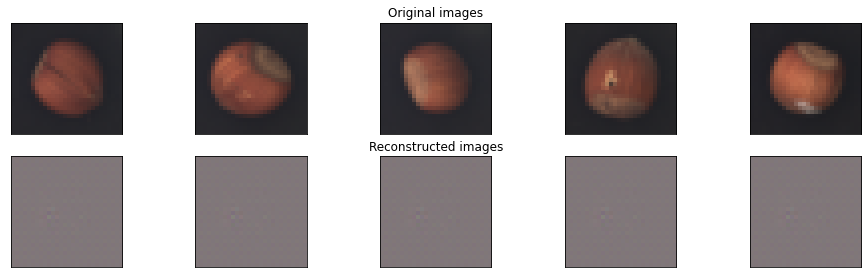

	 partial train loss (single batch): 0.097733
	 partial train loss (single batch): 0.099011
	 partial train loss (single batch): 0.096019
	 partial train loss (single batch): 0.097363
	 partial train loss (single batch): 0.095632
	 partial train loss (single batch): 0.095555
	 partial train loss (single batch): 0.094016
	 partial train loss (single batch): 0.093966
	 partial train loss (single batch): 0.092827
	 partial train loss (single batch): 0.091458
	 partial train loss (single batch): 0.090383
	 partial train loss (single batch): 0.091858
	 partial train loss (single batch): 0.090584

 EPOCH 2/80 	 train loss 0.09433870017528534 	 val loss 0.08026725053787231


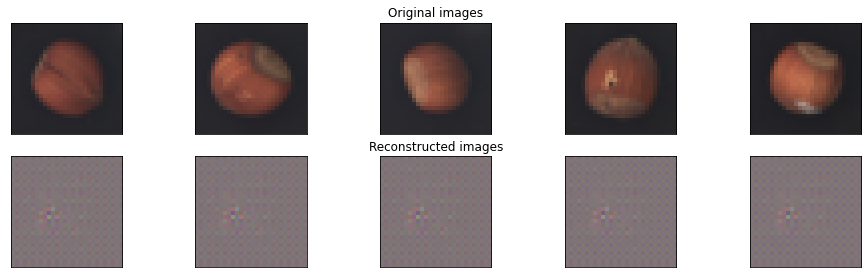

	 partial train loss (single batch): 0.091802
	 partial train loss (single batch): 0.088028
	 partial train loss (single batch): 0.087036
	 partial train loss (single batch): 0.088122
	 partial train loss (single batch): 0.086751
	 partial train loss (single batch): 0.087902
	 partial train loss (single batch): 0.084860
	 partial train loss (single batch): 0.087543
	 partial train loss (single batch): 0.086558
	 partial train loss (single batch): 0.084100
	 partial train loss (single batch): 0.085037
	 partial train loss (single batch): 0.083949
	 partial train loss (single batch): 0.085065

 EPOCH 3/80 	 train loss 0.08667337894439697 	 val loss 0.07420005649328232


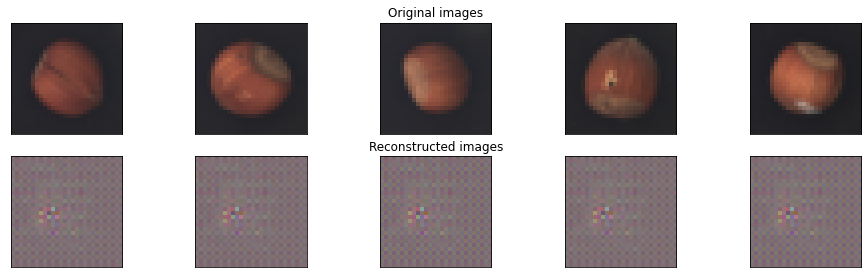

	 partial train loss (single batch): 0.082440
	 partial train loss (single batch): 0.082730
	 partial train loss (single batch): 0.080714
	 partial train loss (single batch): 0.080452
	 partial train loss (single batch): 0.081755
	 partial train loss (single batch): 0.078154
	 partial train loss (single batch): 0.077907
	 partial train loss (single batch): 0.077757
	 partial train loss (single batch): 0.077083
	 partial train loss (single batch): 0.077487
	 partial train loss (single batch): 0.077354
	 partial train loss (single batch): 0.077002
	 partial train loss (single batch): 0.076289

 EPOCH 4/80 	 train loss 0.07900966703891754 	 val loss 0.06767111271619797


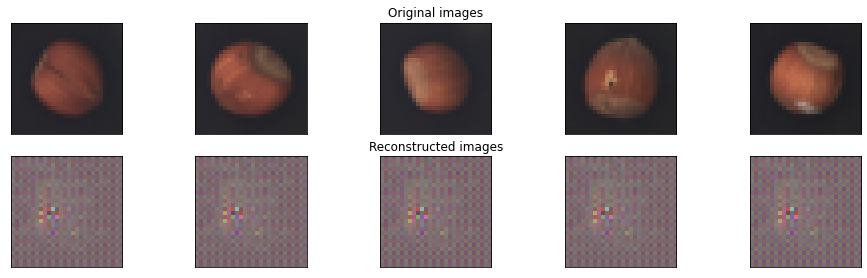

	 partial train loss (single batch): 0.072389
	 partial train loss (single batch): 0.074092
	 partial train loss (single batch): 0.074229
	 partial train loss (single batch): 0.072862
	 partial train loss (single batch): 0.073182
	 partial train loss (single batch): 0.071547
	 partial train loss (single batch): 0.073914
	 partial train loss (single batch): 0.069948
	 partial train loss (single batch): 0.070193
	 partial train loss (single batch): 0.068910
	 partial train loss (single batch): 0.068402
	 partial train loss (single batch): 0.068755
	 partial train loss (single batch): 0.067004

 EPOCH 5/80 	 train loss 0.0711866244673729 	 val loss 0.06095648929476738


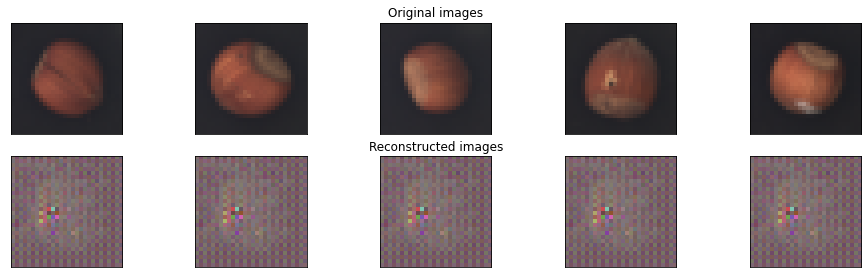

	 partial train loss (single batch): 0.066725
	 partial train loss (single batch): 0.067313
	 partial train loss (single batch): 0.065869
	 partial train loss (single batch): 0.065977
	 partial train loss (single batch): 0.065353
	 partial train loss (single batch): 0.062988
	 partial train loss (single batch): 0.064317
	 partial train loss (single batch): 0.064207
	 partial train loss (single batch): 0.062562
	 partial train loss (single batch): 0.059808
	 partial train loss (single batch): 0.061414
	 partial train loss (single batch): 0.059282
	 partial train loss (single batch): 0.057150

 EPOCH 6/80 	 train loss 0.0633050873875618 	 val loss 0.05350163206458092


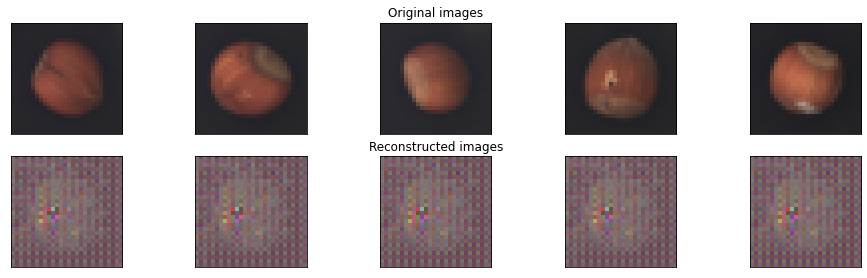

	 partial train loss (single batch): 0.059181
	 partial train loss (single batch): 0.059361
	 partial train loss (single batch): 0.058157
	 partial train loss (single batch): 0.057879
	 partial train loss (single batch): 0.056453
	 partial train loss (single batch): 0.055888
	 partial train loss (single batch): 0.056544
	 partial train loss (single batch): 0.055767
	 partial train loss (single batch): 0.053864
	 partial train loss (single batch): 0.055310
	 partial train loss (single batch): 0.053929
	 partial train loss (single batch): 0.053435
	 partial train loss (single batch): 0.055037

 EPOCH 7/80 	 train loss 0.056215837597846985 	 val loss 0.04643366113305092


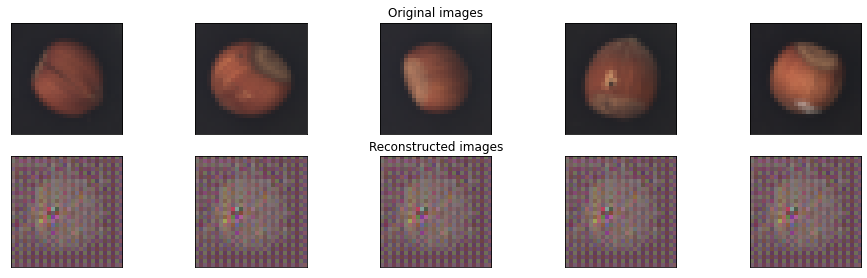

	 partial train loss (single batch): 0.051564
	 partial train loss (single batch): 0.052737
	 partial train loss (single batch): 0.050340
	 partial train loss (single batch): 0.051051
	 partial train loss (single batch): 0.050533
	 partial train loss (single batch): 0.048409
	 partial train loss (single batch): 0.049821
	 partial train loss (single batch): 0.048715
	 partial train loss (single batch): 0.047788
	 partial train loss (single batch): 0.047274
	 partial train loss (single batch): 0.048041
	 partial train loss (single batch): 0.047475
	 partial train loss (single batch): 0.046534

 EPOCH 8/80 	 train loss 0.04925243556499481 	 val loss 0.04019040986895561


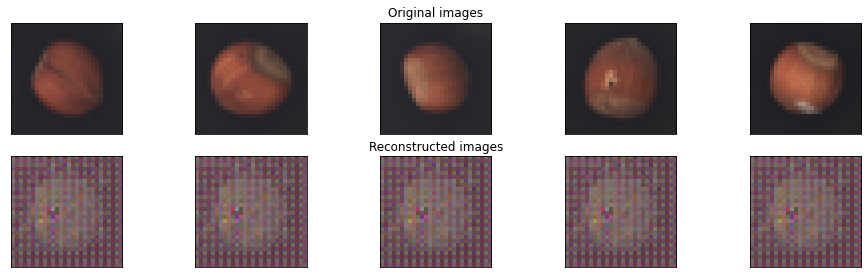

	 partial train loss (single batch): 0.046578
	 partial train loss (single batch): 0.045336
	 partial train loss (single batch): 0.045110
	 partial train loss (single batch): 0.043748
	 partial train loss (single batch): 0.044203
	 partial train loss (single batch): 0.042364
	 partial train loss (single batch): 0.043432
	 partial train loss (single batch): 0.042358
	 partial train loss (single batch): 0.042643
	 partial train loss (single batch): 0.040289
	 partial train loss (single batch): 0.040689
	 partial train loss (single batch): 0.041200
	 partial train loss (single batch): 0.040537

 EPOCH 9/80 	 train loss 0.0429605096578598 	 val loss 0.03483732417225838


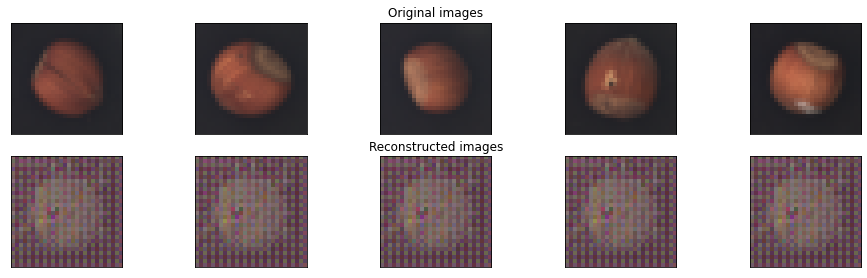

	 partial train loss (single batch): 0.038260
	 partial train loss (single batch): 0.039881
	 partial train loss (single batch): 0.038232
	 partial train loss (single batch): 0.038544
	 partial train loss (single batch): 0.037714
	 partial train loss (single batch): 0.036952
	 partial train loss (single batch): 0.037143
	 partial train loss (single batch): 0.037760
	 partial train loss (single batch): 0.036253
	 partial train loss (single batch): 0.035539
	 partial train loss (single batch): 0.036746
	 partial train loss (single batch): 0.034301
	 partial train loss (single batch): 0.035712

 EPOCH 10/80 	 train loss 0.037156686186790466 	 val loss 0.02960951067507267


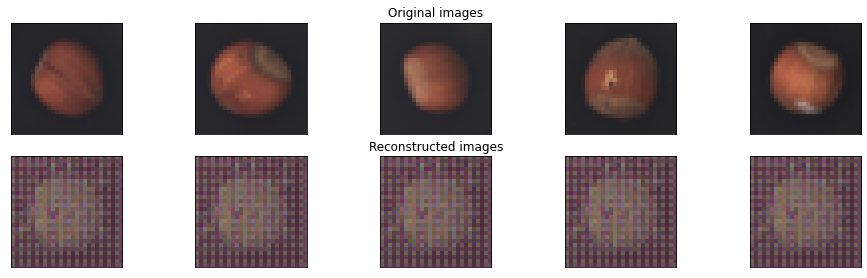

	 partial train loss (single batch): 0.034238
	 partial train loss (single batch): 0.033267
	 partial train loss (single batch): 0.033570
	 partial train loss (single batch): 0.032961
	 partial train loss (single batch): 0.033046
	 partial train loss (single batch): 0.032756
	 partial train loss (single batch): 0.031208
	 partial train loss (single batch): 0.030687
	 partial train loss (single batch): 0.030488
	 partial train loss (single batch): 0.031473
	 partial train loss (single batch): 0.030276
	 partial train loss (single batch): 0.028895
	 partial train loss (single batch): 0.030561

 EPOCH 11/80 	 train loss 0.031801942735910416 	 val loss 0.024802764877676964


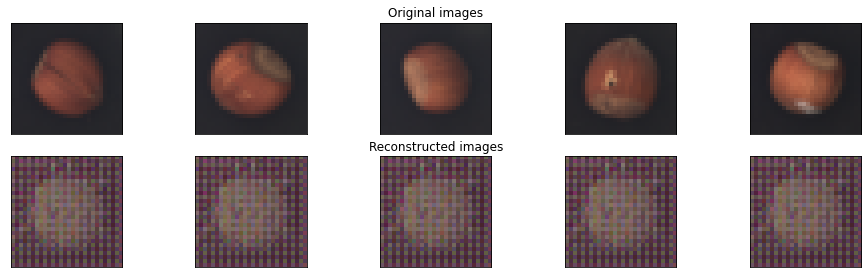

	 partial train loss (single batch): 0.028978
	 partial train loss (single batch): 0.028210
	 partial train loss (single batch): 0.029011
	 partial train loss (single batch): 0.028014
	 partial train loss (single batch): 0.028598
	 partial train loss (single batch): 0.027166
	 partial train loss (single batch): 0.026894
	 partial train loss (single batch): 0.026717
	 partial train loss (single batch): 0.026354
	 partial train loss (single batch): 0.025102
	 partial train loss (single batch): 0.026257
	 partial train loss (single batch): 0.025278
	 partial train loss (single batch): 0.025085

 EPOCH 12/80 	 train loss 0.027051009237766266 	 val loss 0.021223824471235275


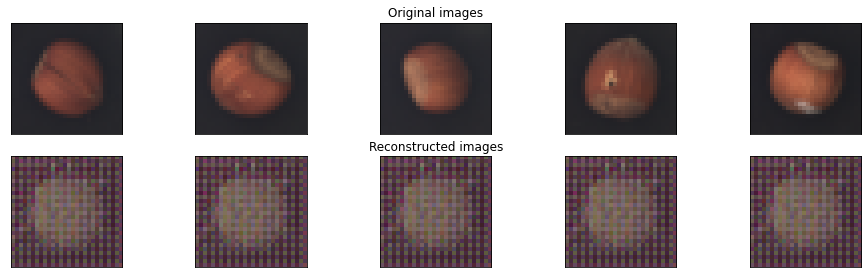

	 partial train loss (single batch): 0.025238
	 partial train loss (single batch): 0.024039
	 partial train loss (single batch): 0.025101
	 partial train loss (single batch): 0.023916
	 partial train loss (single batch): 0.023406
	 partial train loss (single batch): 0.024132
	 partial train loss (single batch): 0.021476
	 partial train loss (single batch): 0.022898
	 partial train loss (single batch): 0.022193
	 partial train loss (single batch): 0.022229
	 partial train loss (single batch): 0.021906
	 partial train loss (single batch): 0.020850
	 partial train loss (single batch): 0.022329

 EPOCH 13/80 	 train loss 0.023054776713252068 	 val loss 0.017823904752731323


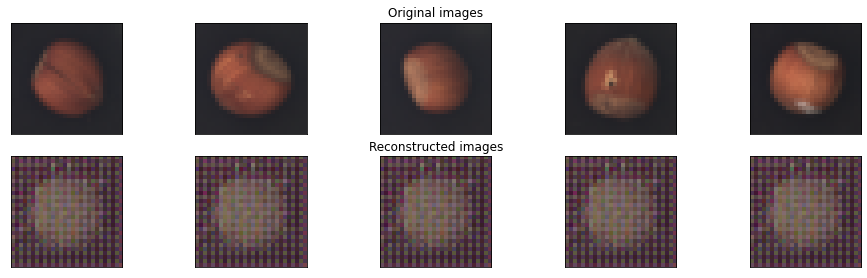

	 partial train loss (single batch): 0.021071
	 partial train loss (single batch): 0.021571
	 partial train loss (single batch): 0.020190
	 partial train loss (single batch): 0.020020
	 partial train loss (single batch): 0.019507
	 partial train loss (single batch): 0.019694
	 partial train loss (single batch): 0.019158
	 partial train loss (single batch): 0.019752
	 partial train loss (single batch): 0.019278
	 partial train loss (single batch): 0.019047
	 partial train loss (single batch): 0.018392
	 partial train loss (single batch): 0.018435
	 partial train loss (single batch): 0.018407

 EPOCH 14/80 	 train loss 0.019578613340854645 	 val loss 0.014992251992225647


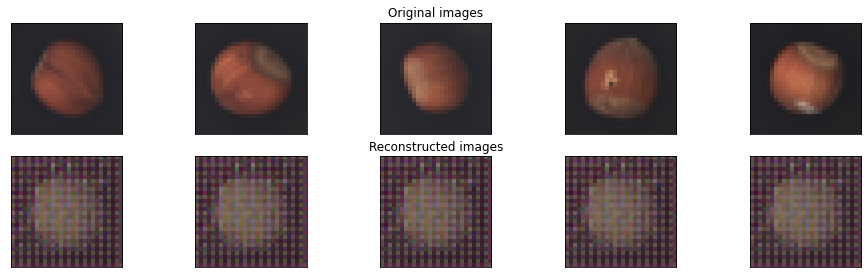

	 partial train loss (single batch): 0.017932
	 partial train loss (single batch): 0.017185
	 partial train loss (single batch): 0.017634
	 partial train loss (single batch): 0.017276
	 partial train loss (single batch): 0.018033
	 partial train loss (single batch): 0.016993
	 partial train loss (single batch): 0.016051
	 partial train loss (single batch): 0.017169
	 partial train loss (single batch): 0.016766
	 partial train loss (single batch): 0.016178
	 partial train loss (single batch): 0.015374
	 partial train loss (single batch): 0.015671
	 partial train loss (single batch): 0.014772

 EPOCH 15/80 	 train loss 0.016694985330104828 	 val loss 0.013087958097457886


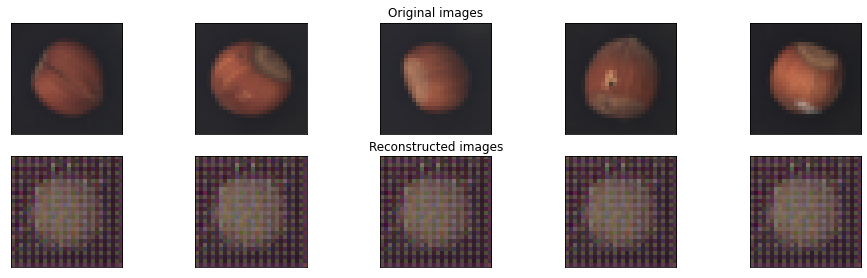

	 partial train loss (single batch): 0.015353
	 partial train loss (single batch): 0.015330
	 partial train loss (single batch): 0.015245
	 partial train loss (single batch): 0.014878
	 partial train loss (single batch): 0.014381
	 partial train loss (single batch): 0.014589
	 partial train loss (single batch): 0.014538
	 partial train loss (single batch): 0.014385
	 partial train loss (single batch): 0.013779
	 partial train loss (single batch): 0.014066
	 partial train loss (single batch): 0.013541
	 partial train loss (single batch): 0.014094
	 partial train loss (single batch): 0.013725

 EPOCH 16/80 	 train loss 0.014454225078225136 	 val loss 0.011112594045698643


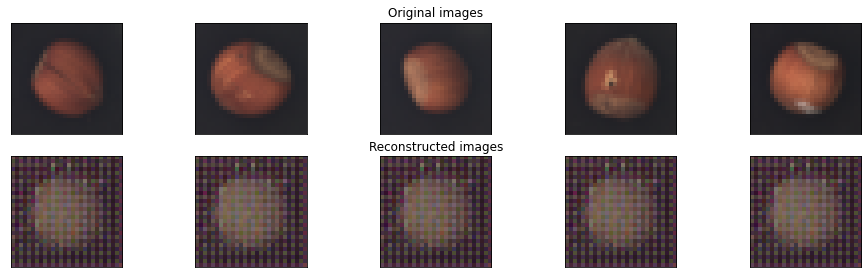

	 partial train loss (single batch): 0.013740
	 partial train loss (single batch): 0.013515
	 partial train loss (single batch): 0.013229
	 partial train loss (single batch): 0.012519
	 partial train loss (single batch): 0.012894
	 partial train loss (single batch): 0.012800
	 partial train loss (single batch): 0.012406
	 partial train loss (single batch): 0.011978
	 partial train loss (single batch): 0.012376
	 partial train loss (single batch): 0.011737
	 partial train loss (single batch): 0.012206
	 partial train loss (single batch): 0.012104
	 partial train loss (single batch): 0.011878

 EPOCH 17/80 	 train loss 0.012567754834890366 	 val loss 0.009537221863865852


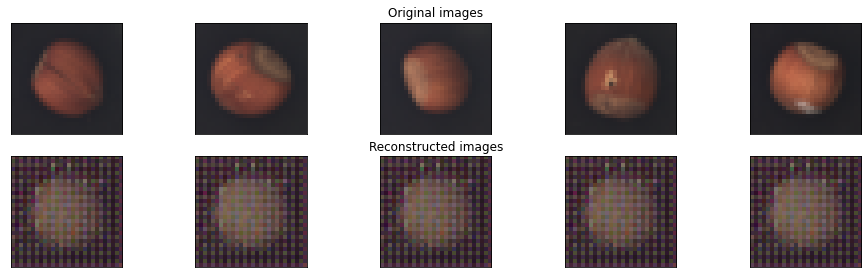

	 partial train loss (single batch): 0.011288
	 partial train loss (single batch): 0.010998
	 partial train loss (single batch): 0.011808
	 partial train loss (single batch): 0.011024
	 partial train loss (single batch): 0.011101
	 partial train loss (single batch): 0.011151
	 partial train loss (single batch): 0.011076
	 partial train loss (single batch): 0.011216
	 partial train loss (single batch): 0.011215
	 partial train loss (single batch): 0.010484
	 partial train loss (single batch): 0.011014
	 partial train loss (single batch): 0.010410
	 partial train loss (single batch): 0.010575

 EPOCH 18/80 	 train loss 0.011027580127120018 	 val loss 0.008492414839565754


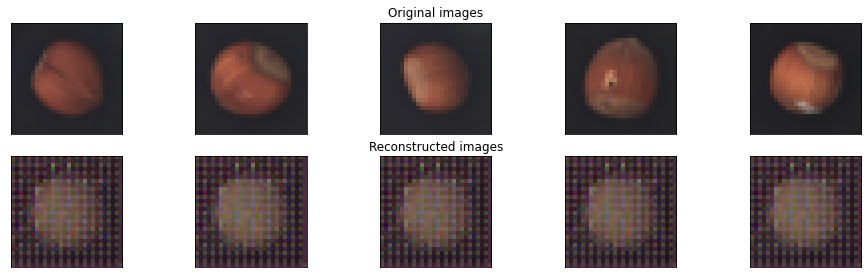

	 partial train loss (single batch): 0.010320
	 partial train loss (single batch): 0.010243
	 partial train loss (single batch): 0.010469
	 partial train loss (single batch): 0.010095
	 partial train loss (single batch): 0.010007
	 partial train loss (single batch): 0.009479
	 partial train loss (single batch): 0.009610
	 partial train loss (single batch): 0.009382
	 partial train loss (single batch): 0.009578
	 partial train loss (single batch): 0.009516
	 partial train loss (single batch): 0.009180
	 partial train loss (single batch): 0.009258
	 partial train loss (single batch): 0.010467

 EPOCH 19/80 	 train loss 0.009815537370741367 	 val loss 0.007524748798459768


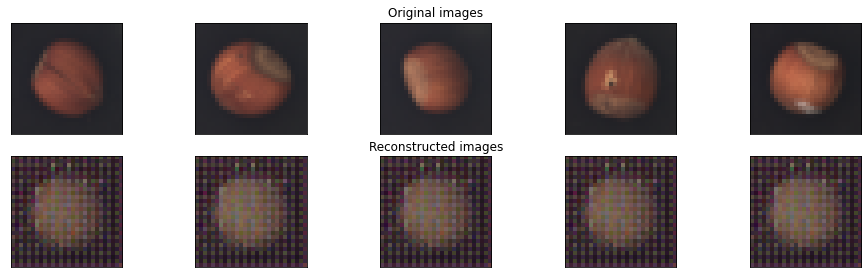

	 partial train loss (single batch): 0.009585
	 partial train loss (single batch): 0.009415
	 partial train loss (single batch): 0.008793
	 partial train loss (single batch): 0.008490
	 partial train loss (single batch): 0.008535
	 partial train loss (single batch): 0.009054
	 partial train loss (single batch): 0.008620
	 partial train loss (single batch): 0.008367
	 partial train loss (single batch): 0.008117
	 partial train loss (single batch): 0.008227
	 partial train loss (single batch): 0.008047
	 partial train loss (single batch): 0.008627
	 partial train loss (single batch): 0.009048

 EPOCH 20/80 	 train loss 0.008686672896146774 	 val loss 0.006643813569098711


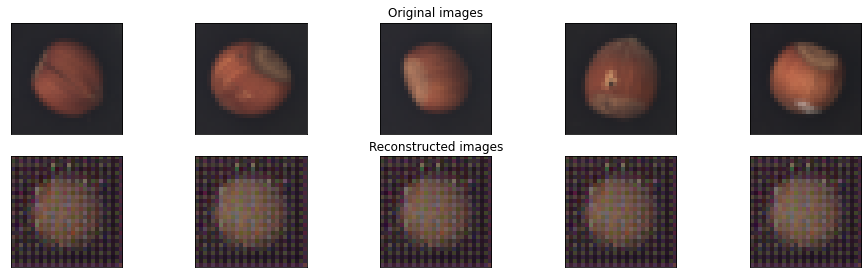

	 partial train loss (single batch): 0.008364
	 partial train loss (single batch): 0.008392
	 partial train loss (single batch): 0.008002
	 partial train loss (single batch): 0.008204
	 partial train loss (single batch): 0.007728
	 partial train loss (single batch): 0.007691
	 partial train loss (single batch): 0.007678
	 partial train loss (single batch): 0.007550
	 partial train loss (single batch): 0.007672
	 partial train loss (single batch): 0.007077
	 partial train loss (single batch): 0.007462
	 partial train loss (single batch): 0.007320
	 partial train loss (single batch): 0.006792

 EPOCH 21/80 	 train loss 0.007686947006732225 	 val loss 0.006259940564632416


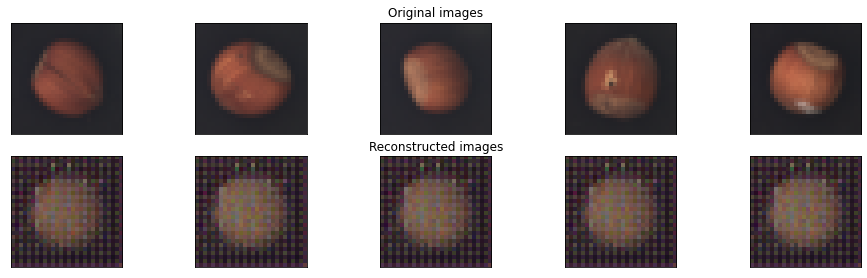

	 partial train loss (single batch): 0.007049
	 partial train loss (single batch): 0.007201
	 partial train loss (single batch): 0.007785
	 partial train loss (single batch): 0.007276
	 partial train loss (single batch): 0.006848
	 partial train loss (single batch): 0.006802
	 partial train loss (single batch): 0.007126
	 partial train loss (single batch): 0.007142
	 partial train loss (single batch): 0.006853
	 partial train loss (single batch): 0.006692
	 partial train loss (single batch): 0.006172
	 partial train loss (single batch): 0.006764
	 partial train loss (single batch): 0.006751

 EPOCH 22/80 	 train loss 0.006958418060094118 	 val loss 0.005912282969802618


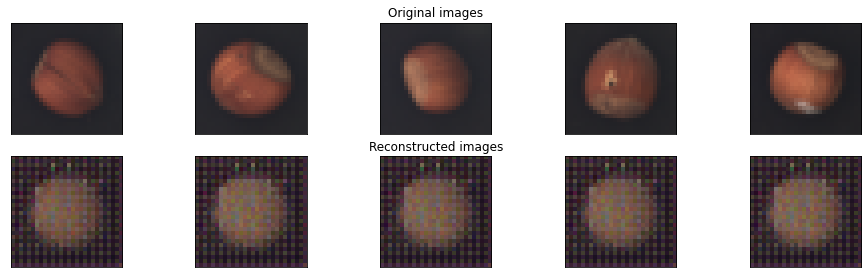

	 partial train loss (single batch): 0.006627
	 partial train loss (single batch): 0.006429
	 partial train loss (single batch): 0.006540
	 partial train loss (single batch): 0.006624
	 partial train loss (single batch): 0.006371
	 partial train loss (single batch): 0.006266
	 partial train loss (single batch): 0.006624
	 partial train loss (single batch): 0.006240
	 partial train loss (single batch): 0.006035
	 partial train loss (single batch): 0.006368
	 partial train loss (single batch): 0.006162
	 partial train loss (single batch): 0.005864
	 partial train loss (single batch): 0.005763

 EPOCH 23/80 	 train loss 0.006300979293882847 	 val loss 0.005057948641479015


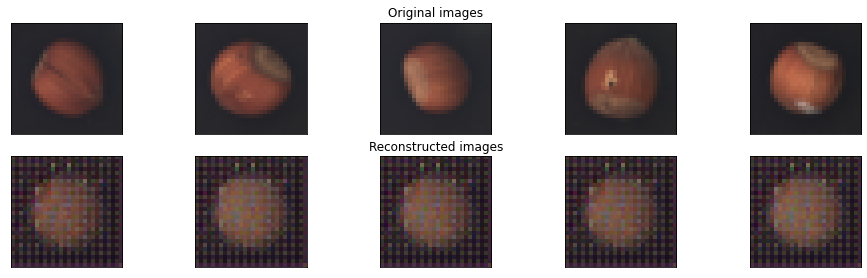

	 partial train loss (single batch): 0.005581
	 partial train loss (single batch): 0.006059
	 partial train loss (single batch): 0.006107
	 partial train loss (single batch): 0.006006
	 partial train loss (single batch): 0.005690
	 partial train loss (single batch): 0.005793
	 partial train loss (single batch): 0.005629
	 partial train loss (single batch): 0.005800
	 partial train loss (single batch): 0.005693
	 partial train loss (single batch): 0.005574
	 partial train loss (single batch): 0.005921
	 partial train loss (single batch): 0.005813
	 partial train loss (single batch): 0.005800

 EPOCH 24/80 	 train loss 0.005805070977658033 	 val loss 0.004695436451584101


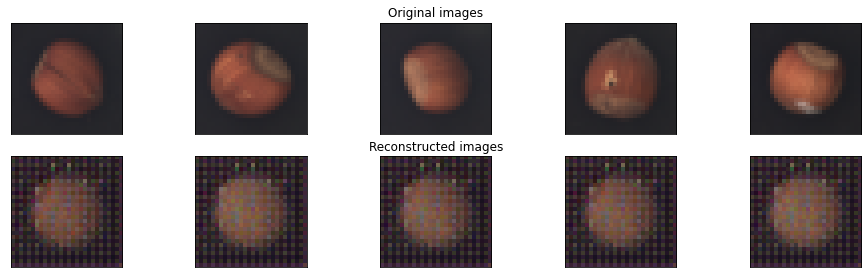

	 partial train loss (single batch): 0.005777
	 partial train loss (single batch): 0.005573
	 partial train loss (single batch): 0.005442
	 partial train loss (single batch): 0.005408
	 partial train loss (single batch): 0.005511
	 partial train loss (single batch): 0.005376
	 partial train loss (single batch): 0.005013
	 partial train loss (single batch): 0.005068
	 partial train loss (single batch): 0.005131
	 partial train loss (single batch): 0.004942
	 partial train loss (single batch): 0.005450
	 partial train loss (single batch): 0.005120
	 partial train loss (single batch): 0.005068

 EPOCH 25/80 	 train loss 0.005298416595906019 	 val loss 0.00456516956910491


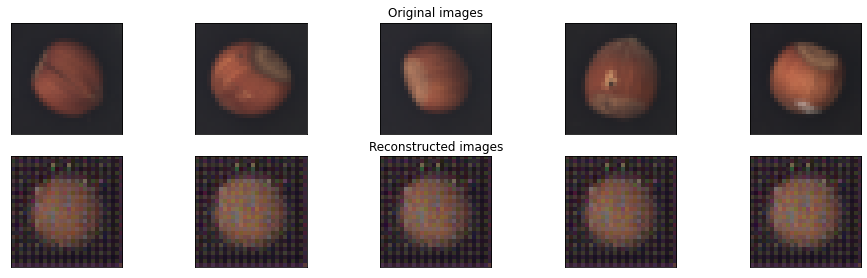

	 partial train loss (single batch): 0.005171
	 partial train loss (single batch): 0.004978
	 partial train loss (single batch): 0.004993
	 partial train loss (single batch): 0.005126
	 partial train loss (single batch): 0.004686
	 partial train loss (single batch): 0.004868
	 partial train loss (single batch): 0.004784
	 partial train loss (single batch): 0.005085
	 partial train loss (single batch): 0.004899
	 partial train loss (single batch): 0.004897
	 partial train loss (single batch): 0.004499
	 partial train loss (single batch): 0.004740
	 partial train loss (single batch): 0.005326

 EPOCH 26/80 	 train loss 0.004927055910229683 	 val loss 0.004221146926283836


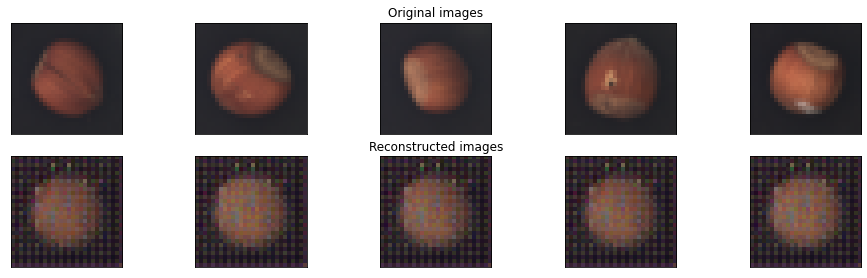

	 partial train loss (single batch): 0.004660
	 partial train loss (single batch): 0.004909
	 partial train loss (single batch): 0.004757
	 partial train loss (single batch): 0.004706
	 partial train loss (single batch): 0.004279
	 partial train loss (single batch): 0.004574
	 partial train loss (single batch): 0.004472
	 partial train loss (single batch): 0.004768
	 partial train loss (single batch): 0.004460
	 partial train loss (single batch): 0.004459
	 partial train loss (single batch): 0.004066
	 partial train loss (single batch): 0.004643
	 partial train loss (single batch): 0.004169

 EPOCH 27/80 	 train loss 0.0045323786325752735 	 val loss 0.0038804588839411736


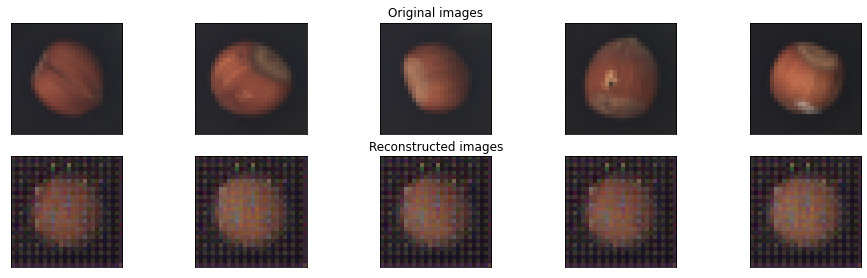

	 partial train loss (single batch): 0.004457
	 partial train loss (single batch): 0.004242
	 partial train loss (single batch): 0.004300
	 partial train loss (single batch): 0.004064
	 partial train loss (single batch): 0.004070
	 partial train loss (single batch): 0.004206
	 partial train loss (single batch): 0.004467
	 partial train loss (single batch): 0.004395
	 partial train loss (single batch): 0.004175
	 partial train loss (single batch): 0.004101
	 partial train loss (single batch): 0.004257
	 partial train loss (single batch): 0.004031
	 partial train loss (single batch): 0.004477

 EPOCH 28/80 	 train loss 0.004249469377100468 	 val loss 0.0036986644845455885


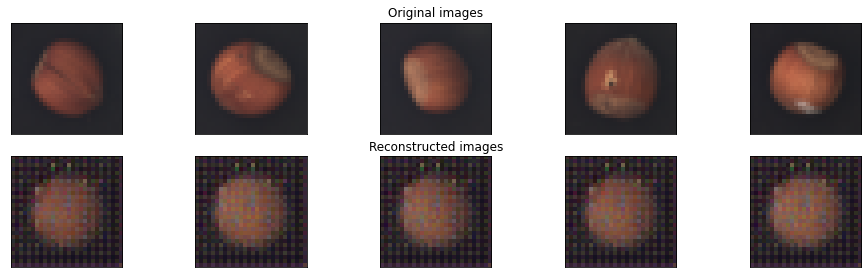

	 partial train loss (single batch): 0.004077
	 partial train loss (single batch): 0.003973
	 partial train loss (single batch): 0.004282
	 partial train loss (single batch): 0.004027
	 partial train loss (single batch): 0.004018
	 partial train loss (single batch): 0.004075
	 partial train loss (single batch): 0.003920
	 partial train loss (single batch): 0.003789
	 partial train loss (single batch): 0.004025
	 partial train loss (single batch): 0.003617
	 partial train loss (single batch): 0.003890
	 partial train loss (single batch): 0.003858
	 partial train loss (single batch): 0.003874

 EPOCH 29/80 	 train loss 0.00395576236769557 	 val loss 0.0035032497253268957


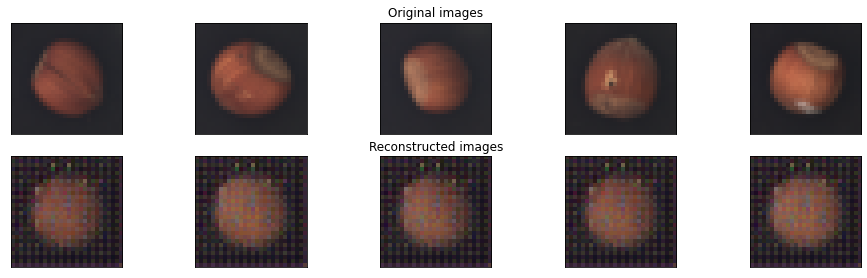

	 partial train loss (single batch): 0.003667
	 partial train loss (single batch): 0.003905
	 partial train loss (single batch): 0.003637
	 partial train loss (single batch): 0.003923
	 partial train loss (single batch): 0.003788
	 partial train loss (single batch): 0.003791
	 partial train loss (single batch): 0.003625
	 partial train loss (single batch): 0.003822
	 partial train loss (single batch): 0.003744
	 partial train loss (single batch): 0.003836
	 partial train loss (single batch): 0.003551
	 partial train loss (single batch): 0.003407
	 partial train loss (single batch): 0.003753

 EPOCH 30/80 	 train loss 0.0037267745938152075 	 val loss 0.0034079409670084715


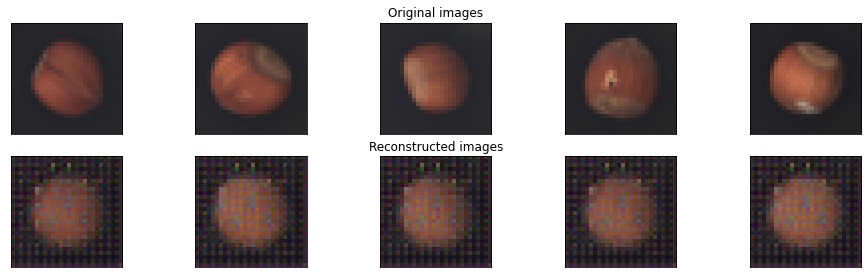

	 partial train loss (single batch): 0.003569
	 partial train loss (single batch): 0.003482
	 partial train loss (single batch): 0.003573
	 partial train loss (single batch): 0.003662
	 partial train loss (single batch): 0.003719
	 partial train loss (single batch): 0.003268
	 partial train loss (single batch): 0.003486
	 partial train loss (single batch): 0.003354
	 partial train loss (single batch): 0.003485
	 partial train loss (single batch): 0.003672
	 partial train loss (single batch): 0.003800
	 partial train loss (single batch): 0.003422
	 partial train loss (single batch): 0.003562

 EPOCH 31/80 	 train loss 0.0035426642280071974 	 val loss 0.0032347769010812044


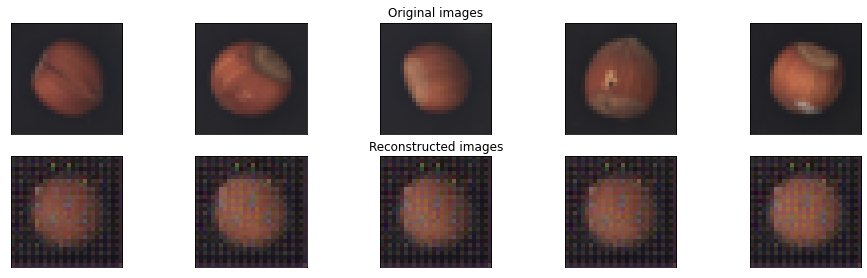

	 partial train loss (single batch): 0.003633
	 partial train loss (single batch): 0.003548
	 partial train loss (single batch): 0.003251
	 partial train loss (single batch): 0.003363
	 partial train loss (single batch): 0.003183
	 partial train loss (single batch): 0.003256
	 partial train loss (single batch): 0.003299
	 partial train loss (single batch): 0.003311
	 partial train loss (single batch): 0.003397
	 partial train loss (single batch): 0.003212
	 partial train loss (single batch): 0.003106
	 partial train loss (single batch): 0.003175
	 partial train loss (single batch): 0.002857

 EPOCH 32/80 	 train loss 0.003276234259828925 	 val loss 0.0030505266040563583


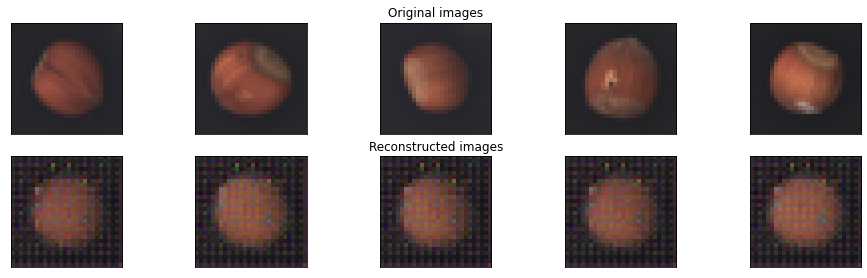

	 partial train loss (single batch): 0.003437
	 partial train loss (single batch): 0.003256
	 partial train loss (single batch): 0.003079
	 partial train loss (single batch): 0.003134
	 partial train loss (single batch): 0.003159
	 partial train loss (single batch): 0.003358
	 partial train loss (single batch): 0.003261
	 partial train loss (single batch): 0.002836
	 partial train loss (single batch): 0.002950
	 partial train loss (single batch): 0.003271
	 partial train loss (single batch): 0.003013
	 partial train loss (single batch): 0.002806
	 partial train loss (single batch): 0.002913

 EPOCH 33/80 	 train loss 0.003113402286544442 	 val loss 0.0030075323302298784


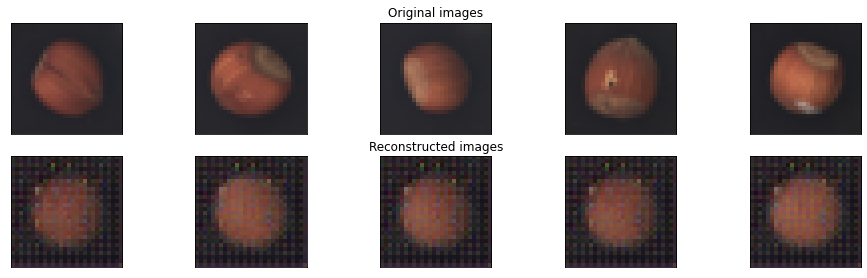

	 partial train loss (single batch): 0.002955
	 partial train loss (single batch): 0.002939
	 partial train loss (single batch): 0.003140
	 partial train loss (single batch): 0.003044
	 partial train loss (single batch): 0.002902
	 partial train loss (single batch): 0.002918
	 partial train loss (single batch): 0.002772
	 partial train loss (single batch): 0.003036
	 partial train loss (single batch): 0.002772
	 partial train loss (single batch): 0.002919
	 partial train loss (single batch): 0.002792
	 partial train loss (single batch): 0.002825
	 partial train loss (single batch): 0.002718

 EPOCH 34/80 	 train loss 0.0029025315307080746 	 val loss 0.0031199967488646507


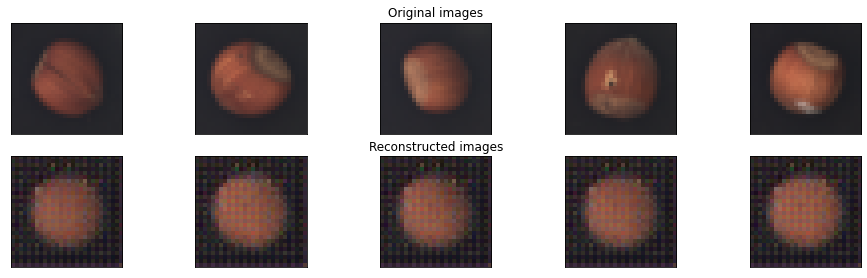

	 partial train loss (single batch): 0.003056
	 partial train loss (single batch): 0.003100
	 partial train loss (single batch): 0.002863
	 partial train loss (single batch): 0.002713
	 partial train loss (single batch): 0.002710
	 partial train loss (single batch): 0.002936
	 partial train loss (single batch): 0.002884
	 partial train loss (single batch): 0.002664
	 partial train loss (single batch): 0.002822
	 partial train loss (single batch): 0.002784
	 partial train loss (single batch): 0.002737
	 partial train loss (single batch): 0.002560
	 partial train loss (single batch): 0.002622

 EPOCH 35/80 	 train loss 0.002804042538627982 	 val loss 0.0033100582659244537


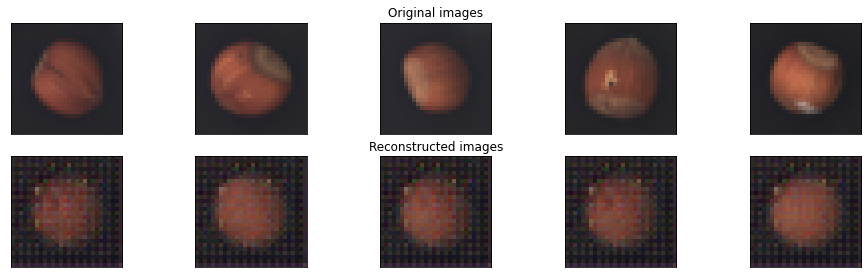

	 partial train loss (single batch): 0.002885
	 partial train loss (single batch): 0.002685
	 partial train loss (single batch): 0.002934
	 partial train loss (single batch): 0.002591
	 partial train loss (single batch): 0.002624
	 partial train loss (single batch): 0.002635
	 partial train loss (single batch): 0.002617
	 partial train loss (single batch): 0.002364
	 partial train loss (single batch): 0.002712
	 partial train loss (single batch): 0.002786
	 partial train loss (single batch): 0.002570
	 partial train loss (single batch): 0.002619
	 partial train loss (single batch): 0.002485

 EPOCH 36/80 	 train loss 0.0026544195134192705 	 val loss 0.0027163708582520485


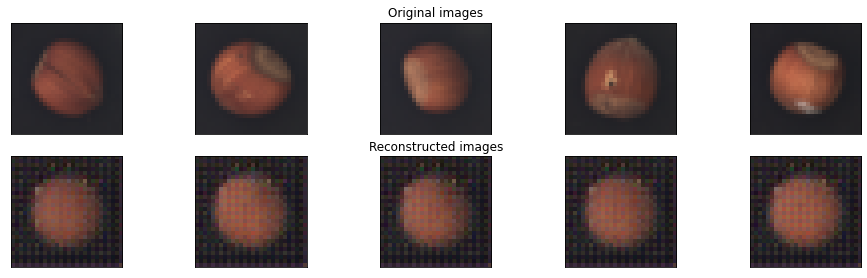

	 partial train loss (single batch): 0.002648
	 partial train loss (single batch): 0.002603
	 partial train loss (single batch): 0.002400
	 partial train loss (single batch): 0.002538
	 partial train loss (single batch): 0.002479
	 partial train loss (single batch): 0.002662
	 partial train loss (single batch): 0.002896
	 partial train loss (single batch): 0.002401
	 partial train loss (single batch): 0.002438
	 partial train loss (single batch): 0.002372
	 partial train loss (single batch): 0.002479
	 partial train loss (single batch): 0.002437
	 partial train loss (single batch): 0.002523

 EPOCH 37/80 	 train loss 0.0025288511533290148 	 val loss 0.002573792589828372


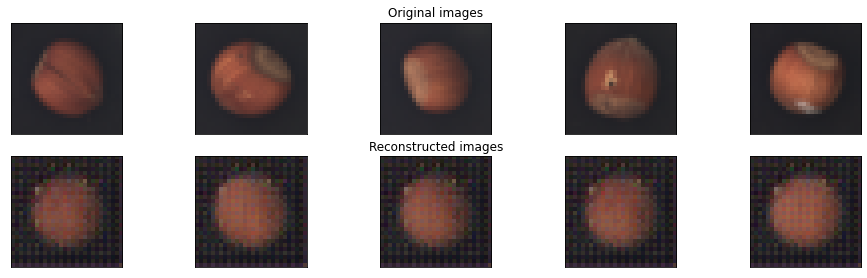

	 partial train loss (single batch): 0.002294
	 partial train loss (single batch): 0.002553
	 partial train loss (single batch): 0.002520
	 partial train loss (single batch): 0.002378
	 partial train loss (single batch): 0.002476
	 partial train loss (single batch): 0.002472
	 partial train loss (single batch): 0.002447
	 partial train loss (single batch): 0.002404
	 partial train loss (single batch): 0.002354
	 partial train loss (single batch): 0.002476
	 partial train loss (single batch): 0.002294
	 partial train loss (single batch): 0.002255
	 partial train loss (single batch): 0.002247

 EPOCH 38/80 	 train loss 0.0023978031240403652 	 val loss 0.00259142043069005


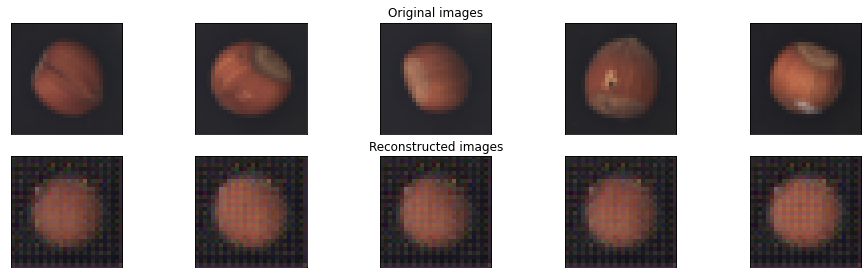

	 partial train loss (single batch): 0.002298
	 partial train loss (single batch): 0.002352
	 partial train loss (single batch): 0.002376
	 partial train loss (single batch): 0.002243
	 partial train loss (single batch): 0.002346
	 partial train loss (single batch): 0.002344
	 partial train loss (single batch): 0.002195
	 partial train loss (single batch): 0.002191
	 partial train loss (single batch): 0.002310
	 partial train loss (single batch): 0.002204
	 partial train loss (single batch): 0.002277
	 partial train loss (single batch): 0.002510
	 partial train loss (single batch): 0.002640

 EPOCH 39/80 	 train loss 0.0023296417202800512 	 val loss 0.0025066889356821775


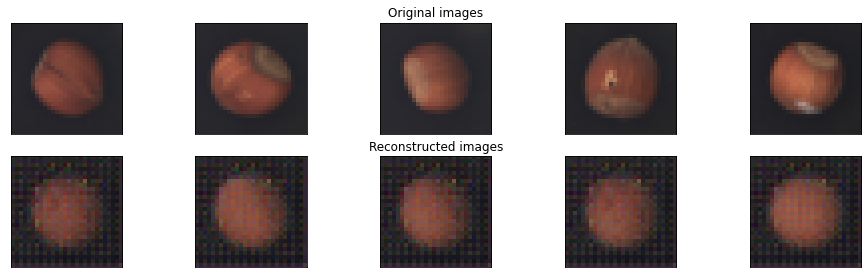

	 partial train loss (single batch): 0.002254
	 partial train loss (single batch): 0.002182
	 partial train loss (single batch): 0.002274
	 partial train loss (single batch): 0.002546
	 partial train loss (single batch): 0.002117
	 partial train loss (single batch): 0.002152
	 partial train loss (single batch): 0.002229
	 partial train loss (single batch): 0.002145
	 partial train loss (single batch): 0.002291
	 partial train loss (single batch): 0.002204
	 partial train loss (single batch): 0.002218
	 partial train loss (single batch): 0.002228
	 partial train loss (single batch): 0.002235

 EPOCH 40/80 	 train loss 0.0022364770993590355 	 val loss 0.002425618004053831


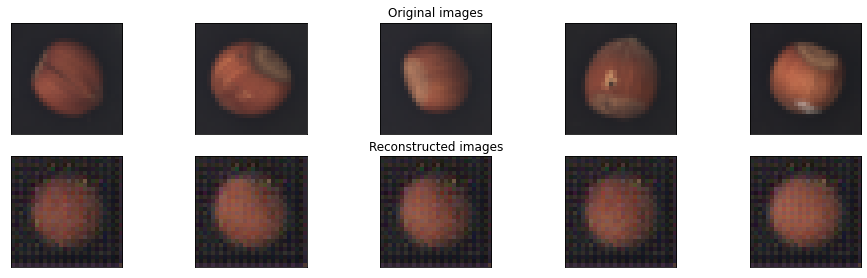

	 partial train loss (single batch): 0.002172
	 partial train loss (single batch): 0.002349
	 partial train loss (single batch): 0.002263
	 partial train loss (single batch): 0.002142
	 partial train loss (single batch): 0.002204
	 partial train loss (single batch): 0.002020
	 partial train loss (single batch): 0.002191
	 partial train loss (single batch): 0.002111
	 partial train loss (single batch): 0.001996
	 partial train loss (single batch): 0.002028
	 partial train loss (single batch): 0.002158
	 partial train loss (single batch): 0.002143
	 partial train loss (single batch): 0.002457

 EPOCH 41/80 	 train loss 0.0021718412172049284 	 val loss 0.0023196155671030283


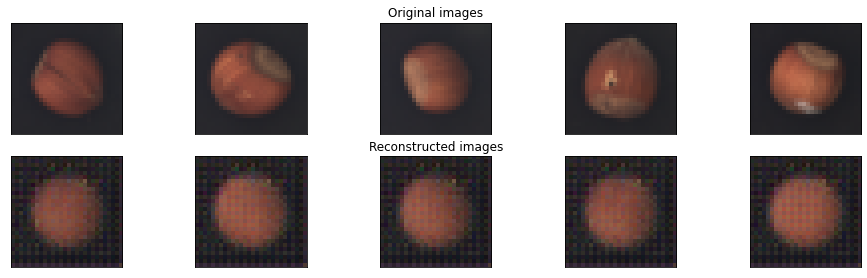

	 partial train loss (single batch): 0.002231
	 partial train loss (single batch): 0.002084
	 partial train loss (single batch): 0.002209
	 partial train loss (single batch): 0.001988
	 partial train loss (single batch): 0.002057
	 partial train loss (single batch): 0.002078
	 partial train loss (single batch): 0.002009
	 partial train loss (single batch): 0.002031
	 partial train loss (single batch): 0.002113
	 partial train loss (single batch): 0.002110
	 partial train loss (single batch): 0.002110
	 partial train loss (single batch): 0.002056
	 partial train loss (single batch): 0.002124

 EPOCH 42/80 	 train loss 0.002092390088364482 	 val loss 0.002365025458857417


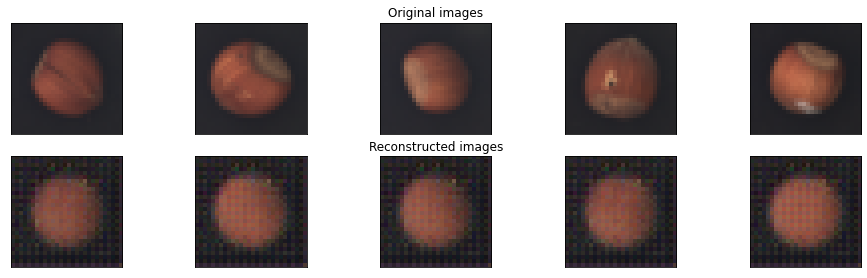

	 partial train loss (single batch): 0.001995
	 partial train loss (single batch): 0.002003
	 partial train loss (single batch): 0.001939
	 partial train loss (single batch): 0.002130
	 partial train loss (single batch): 0.002013
	 partial train loss (single batch): 0.001974
	 partial train loss (single batch): 0.002001
	 partial train loss (single batch): 0.002068
	 partial train loss (single batch): 0.002020
	 partial train loss (single batch): 0.001920
	 partial train loss (single batch): 0.002077
	 partial train loss (single batch): 0.002082
	 partial train loss (single batch): 0.002212

 EPOCH 43/80 	 train loss 0.002033320488408208 	 val loss 0.0022159130312502384


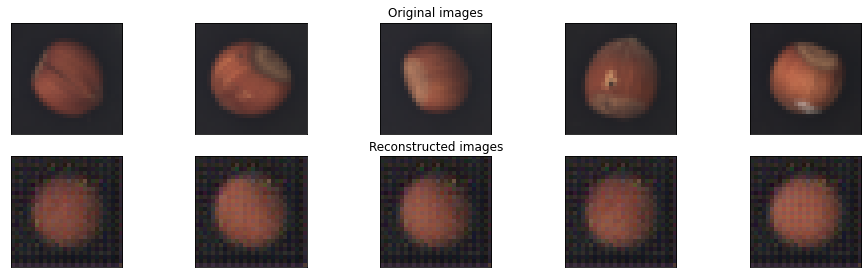

	 partial train loss (single batch): 0.001856
	 partial train loss (single batch): 0.001916
	 partial train loss (single batch): 0.001882
	 partial train loss (single batch): 0.001934
	 partial train loss (single batch): 0.002110
	 partial train loss (single batch): 0.002148
	 partial train loss (single batch): 0.001910
	 partial train loss (single batch): 0.001945
	 partial train loss (single batch): 0.002007
	 partial train loss (single batch): 0.001894
	 partial train loss (single batch): 0.001875
	 partial train loss (single batch): 0.001865
	 partial train loss (single batch): 0.001964

 EPOCH 44/80 	 train loss 0.0019465219229459763 	 val loss 0.002206974197179079


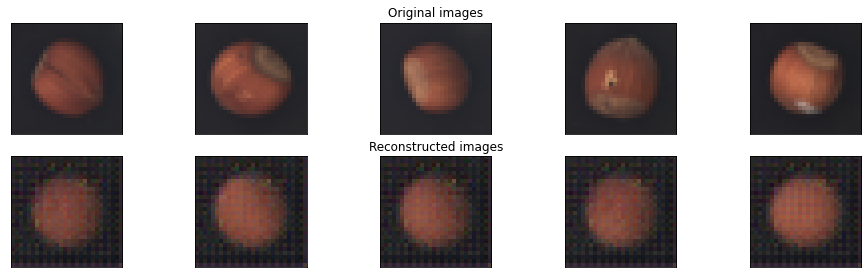

	 partial train loss (single batch): 0.001905
	 partial train loss (single batch): 0.001873
	 partial train loss (single batch): 0.001962
	 partial train loss (single batch): 0.001939
	 partial train loss (single batch): 0.001816
	 partial train loss (single batch): 0.002002
	 partial train loss (single batch): 0.001890
	 partial train loss (single batch): 0.001924
	 partial train loss (single batch): 0.001815
	 partial train loss (single batch): 0.001862
	 partial train loss (single batch): 0.001915
	 partial train loss (single batch): 0.001915
	 partial train loss (single batch): 0.001832

 EPOCH 45/80 	 train loss 0.0018962653120979667 	 val loss 0.002124316059052944


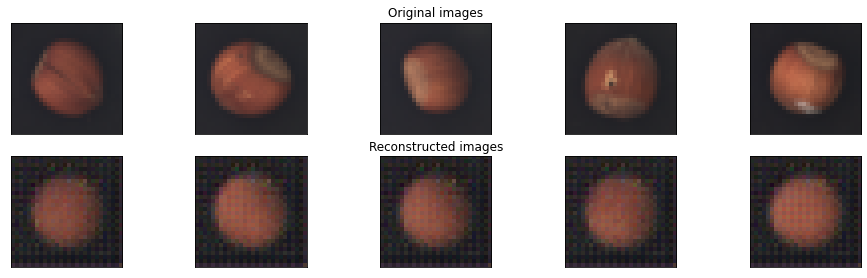

	 partial train loss (single batch): 0.001833
	 partial train loss (single batch): 0.001771
	 partial train loss (single batch): 0.002018
	 partial train loss (single batch): 0.001933
	 partial train loss (single batch): 0.001824
	 partial train loss (single batch): 0.001767
	 partial train loss (single batch): 0.001929
	 partial train loss (single batch): 0.001781
	 partial train loss (single batch): 0.001808
	 partial train loss (single batch): 0.001853
	 partial train loss (single batch): 0.001836
	 partial train loss (single batch): 0.001803
	 partial train loss (single batch): 0.001971

 EPOCH 46/80 	 train loss 0.0018557937582954764 	 val loss 0.0020758723840117455


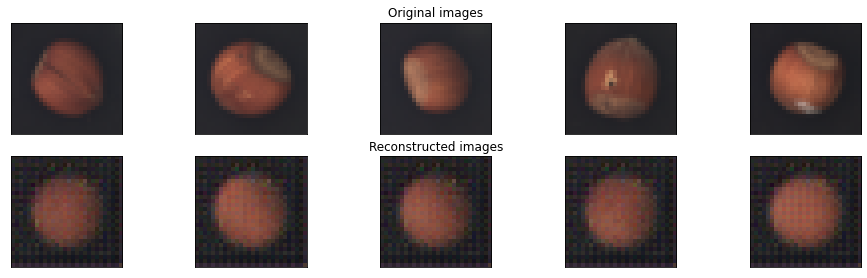

	 partial train loss (single batch): 0.002012
	 partial train loss (single batch): 0.001907
	 partial train loss (single batch): 0.001932
	 partial train loss (single batch): 0.001637
	 partial train loss (single batch): 0.001782
	 partial train loss (single batch): 0.001946
	 partial train loss (single batch): 0.001823
	 partial train loss (single batch): 0.001729
	 partial train loss (single batch): 0.001781
	 partial train loss (single batch): 0.001850
	 partial train loss (single batch): 0.001635
	 partial train loss (single batch): 0.001886
	 partial train loss (single batch): 0.001485

 EPOCH 47/80 	 train loss 0.0018004538724198937 	 val loss 0.0020445396658033133


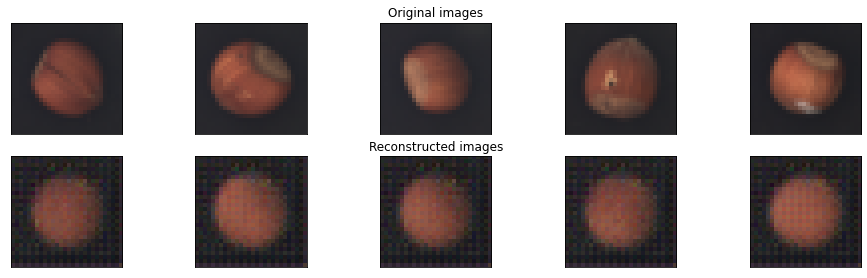

	 partial train loss (single batch): 0.001741
	 partial train loss (single batch): 0.001698
	 partial train loss (single batch): 0.001747
	 partial train loss (single batch): 0.001885
	 partial train loss (single batch): 0.001810
	 partial train loss (single batch): 0.001836
	 partial train loss (single batch): 0.001838
	 partial train loss (single batch): 0.001764
	 partial train loss (single batch): 0.001774
	 partial train loss (single batch): 0.001641
	 partial train loss (single batch): 0.001856
	 partial train loss (single batch): 0.001728
	 partial train loss (single batch): 0.002090

 EPOCH 48/80 	 train loss 0.0018007179023697972 	 val loss 0.002064337721094489


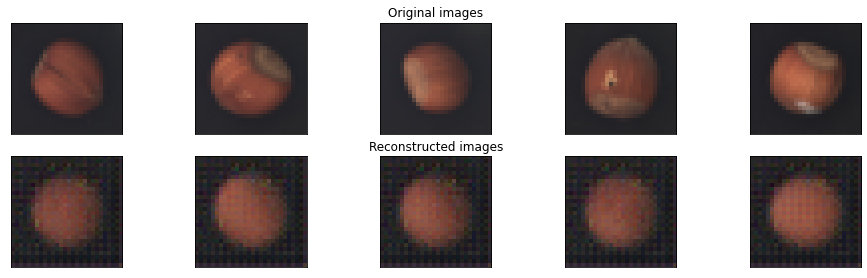

	 partial train loss (single batch): 0.001688
	 partial train loss (single batch): 0.001620
	 partial train loss (single batch): 0.001831
	 partial train loss (single batch): 0.001709
	 partial train loss (single batch): 0.001716
	 partial train loss (single batch): 0.001851
	 partial train loss (single batch): 0.001749
	 partial train loss (single batch): 0.001873
	 partial train loss (single batch): 0.001802
	 partial train loss (single batch): 0.001775
	 partial train loss (single batch): 0.001900
	 partial train loss (single batch): 0.001705
	 partial train loss (single batch): 0.001818

 EPOCH 49/80 	 train loss 0.0017721249023452401 	 val loss 0.0020479997619986534


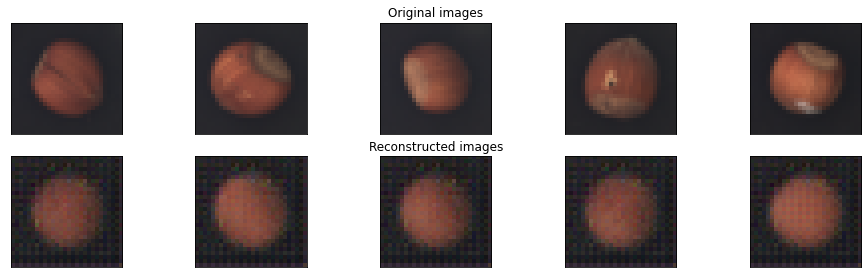

	 partial train loss (single batch): 0.001748
	 partial train loss (single batch): 0.001731
	 partial train loss (single batch): 0.001892
	 partial train loss (single batch): 0.001709
	 partial train loss (single batch): 0.001636
	 partial train loss (single batch): 0.001864
	 partial train loss (single batch): 0.001646
	 partial train loss (single batch): 0.001699
	 partial train loss (single batch): 0.001711
	 partial train loss (single batch): 0.001642
	 partial train loss (single batch): 0.001692
	 partial train loss (single batch): 0.001648
	 partial train loss (single batch): 0.001689

 EPOCH 50/80 	 train loss 0.0017160226125270128 	 val loss 0.0020096797961741686


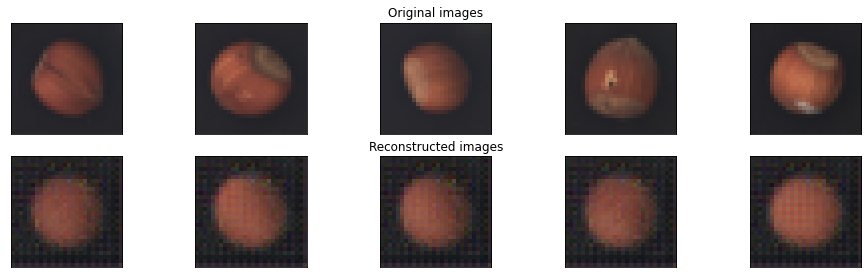

	 partial train loss (single batch): 0.001743
	 partial train loss (single batch): 0.001741
	 partial train loss (single batch): 0.001669
	 partial train loss (single batch): 0.001700
	 partial train loss (single batch): 0.001698
	 partial train loss (single batch): 0.001754
	 partial train loss (single batch): 0.001732
	 partial train loss (single batch): 0.001599
	 partial train loss (single batch): 0.001695
	 partial train loss (single batch): 0.001629
	 partial train loss (single batch): 0.001585
	 partial train loss (single batch): 0.001609
	 partial train loss (single batch): 0.001662

 EPOCH 51/80 	 train loss 0.0016780750593170524 	 val loss 0.0019930696580559015


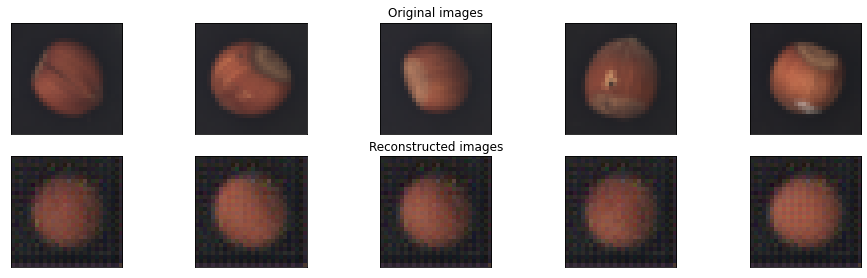

	 partial train loss (single batch): 0.001821
	 partial train loss (single batch): 0.001669
	 partial train loss (single batch): 0.001593
	 partial train loss (single batch): 0.001551
	 partial train loss (single batch): 0.001670
	 partial train loss (single batch): 0.001703
	 partial train loss (single batch): 0.001849
	 partial train loss (single batch): 0.001523
	 partial train loss (single batch): 0.001617
	 partial train loss (single batch): 0.001668
	 partial train loss (single batch): 0.001611
	 partial train loss (single batch): 0.001554
	 partial train loss (single batch): 0.001634

 EPOCH 52/80 	 train loss 0.0016509263077750802 	 val loss 0.0020056634675711393


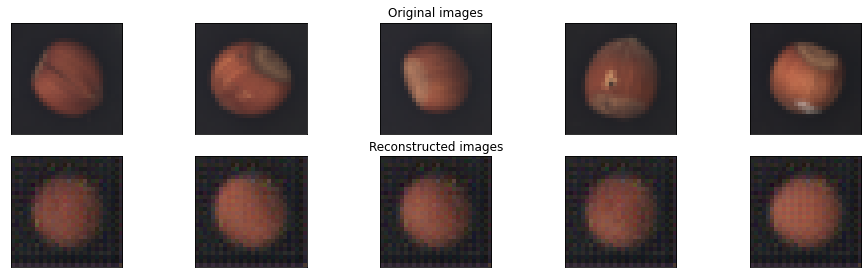

	 partial train loss (single batch): 0.001645
	 partial train loss (single batch): 0.001584
	 partial train loss (single batch): 0.001620
	 partial train loss (single batch): 0.001567
	 partial train loss (single batch): 0.001504
	 partial train loss (single batch): 0.001686
	 partial train loss (single batch): 0.001715
	 partial train loss (single batch): 0.001601
	 partial train loss (single batch): 0.001578
	 partial train loss (single batch): 0.001742
	 partial train loss (single batch): 0.001592
	 partial train loss (single batch): 0.001782
	 partial train loss (single batch): 0.001615

 EPOCH 53/80 	 train loss 0.001633276930078864 	 val loss 0.0019562942907214165


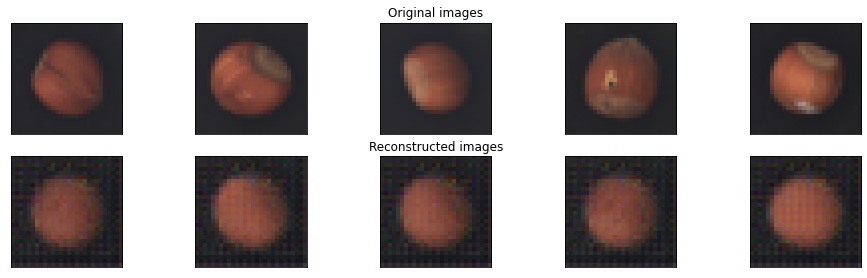

	 partial train loss (single batch): 0.001495
	 partial train loss (single batch): 0.001620
	 partial train loss (single batch): 0.001725
	 partial train loss (single batch): 0.001645
	 partial train loss (single batch): 0.001621
	 partial train loss (single batch): 0.001589
	 partial train loss (single batch): 0.001555
	 partial train loss (single batch): 0.001683
	 partial train loss (single batch): 0.001700
	 partial train loss (single batch): 0.001712
	 partial train loss (single batch): 0.001546
	 partial train loss (single batch): 0.001587
	 partial train loss (single batch): 0.001399

 EPOCH 54/80 	 train loss 0.0016058889450505376 	 val loss 0.0019458556780591607


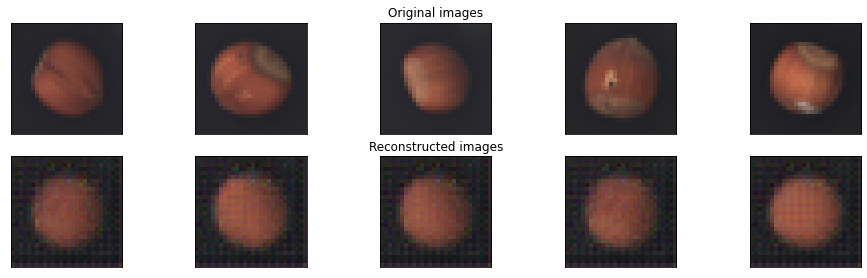

	 partial train loss (single batch): 0.001603
	 partial train loss (single batch): 0.001600
	 partial train loss (single batch): 0.001608
	 partial train loss (single batch): 0.001529
	 partial train loss (single batch): 0.001510
	 partial train loss (single batch): 0.001718
	 partial train loss (single batch): 0.001666
	 partial train loss (single batch): 0.001598
	 partial train loss (single batch): 0.001603
	 partial train loss (single batch): 0.001587
	 partial train loss (single batch): 0.001638
	 partial train loss (single batch): 0.001555
	 partial train loss (single batch): 0.002040

 EPOCH 55/80 	 train loss 0.0016351597150787711 	 val loss 0.0019345772452652454


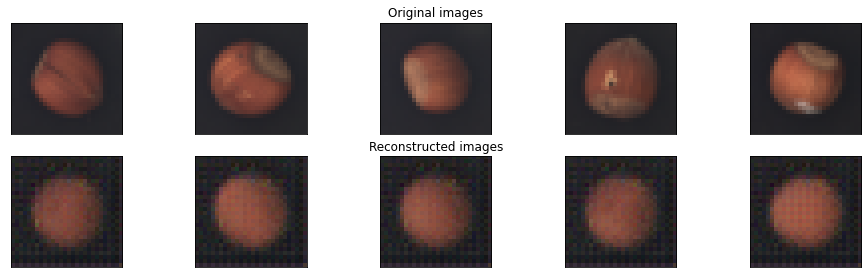

	 partial train loss (single batch): 0.001530
	 partial train loss (single batch): 0.001620
	 partial train loss (single batch): 0.001675
	 partial train loss (single batch): 0.001637
	 partial train loss (single batch): 0.001595
	 partial train loss (single batch): 0.001590
	 partial train loss (single batch): 0.001559
	 partial train loss (single batch): 0.001394
	 partial train loss (single batch): 0.001592
	 partial train loss (single batch): 0.001549
	 partial train loss (single batch): 0.001565
	 partial train loss (single batch): 0.001660
	 partial train loss (single batch): 0.001968

 EPOCH 56/80 	 train loss 0.001610332285054028 	 val loss 0.0020184314344078302


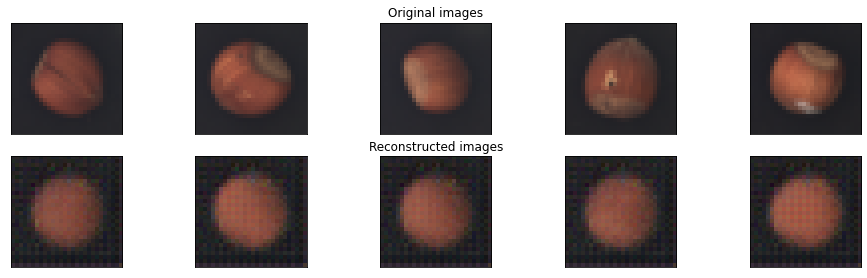

	 partial train loss (single batch): 0.001512
	 partial train loss (single batch): 0.001759
	 partial train loss (single batch): 0.001627
	 partial train loss (single batch): 0.001462
	 partial train loss (single batch): 0.001624
	 partial train loss (single batch): 0.001580
	 partial train loss (single batch): 0.001612
	 partial train loss (single batch): 0.001647
	 partial train loss (single batch): 0.001546
	 partial train loss (single batch): 0.001499
	 partial train loss (single batch): 0.001662
	 partial train loss (single batch): 0.001572
	 partial train loss (single batch): 0.001564

 EPOCH 57/80 	 train loss 0.0015896809054538608 	 val loss 0.0019086855463683605


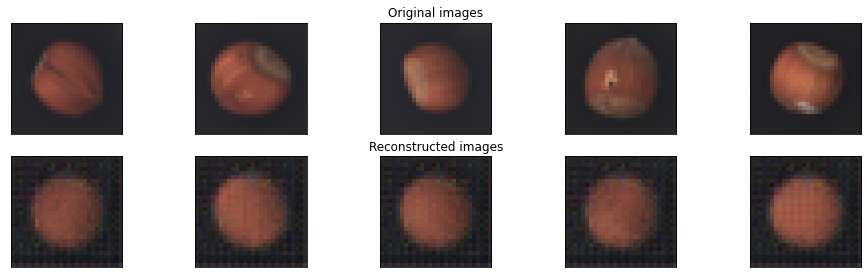

	 partial train loss (single batch): 0.001620
	 partial train loss (single batch): 0.001517
	 partial train loss (single batch): 0.001720
	 partial train loss (single batch): 0.001476
	 partial train loss (single batch): 0.001440
	 partial train loss (single batch): 0.001541
	 partial train loss (single batch): 0.001502
	 partial train loss (single batch): 0.001619
	 partial train loss (single batch): 0.001410
	 partial train loss (single batch): 0.001455
	 partial train loss (single batch): 0.001534
	 partial train loss (single batch): 0.001520
	 partial train loss (single batch): 0.001603

 EPOCH 58/80 	 train loss 0.0015351928304880857 	 val loss 0.0018514072289690375


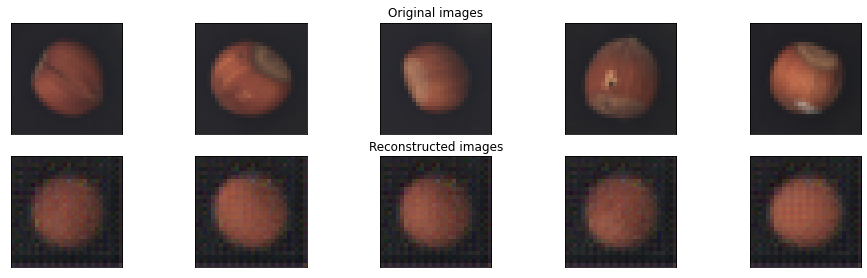

	 partial train loss (single batch): 0.001505
	 partial train loss (single batch): 0.001601
	 partial train loss (single batch): 0.001569
	 partial train loss (single batch): 0.001445
	 partial train loss (single batch): 0.001469
	 partial train loss (single batch): 0.001517
	 partial train loss (single batch): 0.001436
	 partial train loss (single batch): 0.001505
	 partial train loss (single batch): 0.001522
	 partial train loss (single batch): 0.001499
	 partial train loss (single batch): 0.001528
	 partial train loss (single batch): 0.001540
	 partial train loss (single batch): 0.001773

 EPOCH 59/80 	 train loss 0.0015315136406570673 	 val loss 0.0018803643761202693


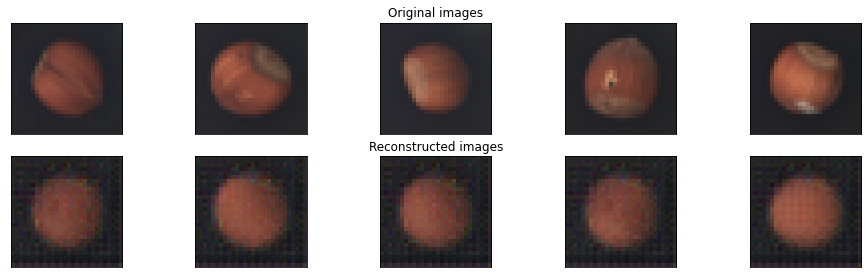

	 partial train loss (single batch): 0.001470
	 partial train loss (single batch): 0.001935
	 partial train loss (single batch): 0.001421
	 partial train loss (single batch): 0.001530
	 partial train loss (single batch): 0.001428
	 partial train loss (single batch): 0.001462
	 partial train loss (single batch): 0.001468
	 partial train loss (single batch): 0.001494
	 partial train loss (single batch): 0.001388
	 partial train loss (single batch): 0.001478
	 partial train loss (single batch): 0.001466
	 partial train loss (single batch): 0.001590
	 partial train loss (single batch): 0.001434

 EPOCH 60/80 	 train loss 0.0015049218200147152 	 val loss 0.0018421078566461802


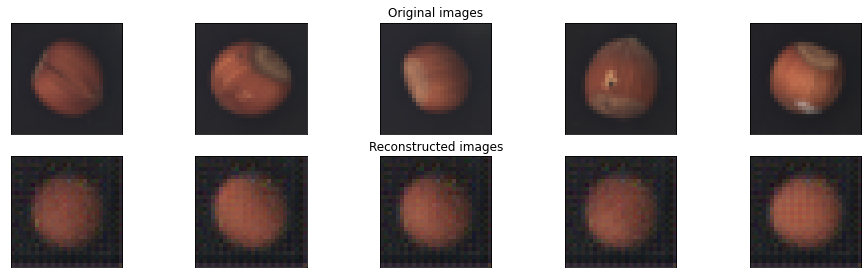

	 partial train loss (single batch): 0.001404
	 partial train loss (single batch): 0.001450
	 partial train loss (single batch): 0.001522
	 partial train loss (single batch): 0.001423
	 partial train loss (single batch): 0.001416
	 partial train loss (single batch): 0.001458
	 partial train loss (single batch): 0.001451
	 partial train loss (single batch): 0.001483
	 partial train loss (single batch): 0.001560
	 partial train loss (single batch): 0.001419
	 partial train loss (single batch): 0.001589
	 partial train loss (single batch): 0.001405
	 partial train loss (single batch): 0.001807

 EPOCH 61/80 	 train loss 0.0014912305632606149 	 val loss 0.001838215976022184


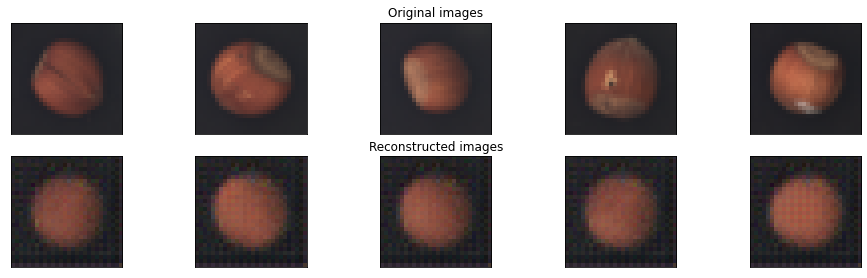

	 partial train loss (single batch): 0.001465
	 partial train loss (single batch): 0.001492
	 partial train loss (single batch): 0.001435
	 partial train loss (single batch): 0.001490
	 partial train loss (single batch): 0.001588
	 partial train loss (single batch): 0.001495
	 partial train loss (single batch): 0.001575
	 partial train loss (single batch): 0.001483
	 partial train loss (single batch): 0.001500
	 partial train loss (single batch): 0.001408
	 partial train loss (single batch): 0.001550
	 partial train loss (single batch): 0.001413
	 partial train loss (single batch): 0.001301

 EPOCH 62/80 	 train loss 0.0014766351087018847 	 val loss 0.0018462683074176311


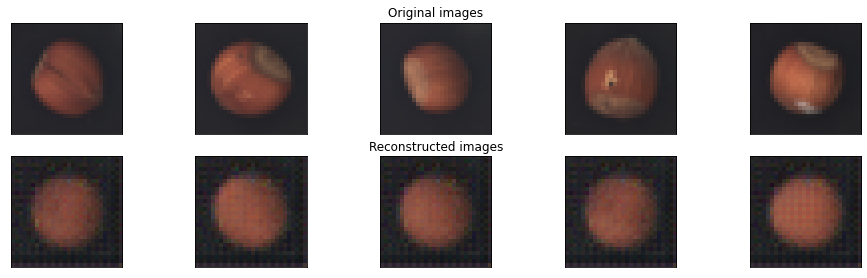

	 partial train loss (single batch): 0.001502
	 partial train loss (single batch): 0.001465
	 partial train loss (single batch): 0.001364
	 partial train loss (single batch): 0.001588
	 partial train loss (single batch): 0.001431
	 partial train loss (single batch): 0.001430
	 partial train loss (single batch): 0.001570
	 partial train loss (single batch): 0.001433
	 partial train loss (single batch): 0.001394
	 partial train loss (single batch): 0.001446
	 partial train loss (single batch): 0.001565
	 partial train loss (single batch): 0.001390
	 partial train loss (single batch): 0.001368

 EPOCH 63/80 	 train loss 0.0014573788503184915 	 val loss 0.0018507854547351599


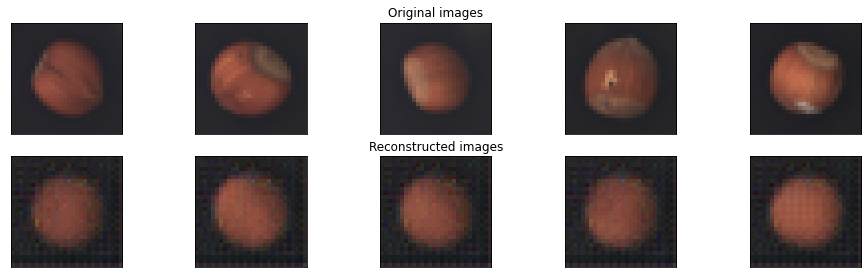

	 partial train loss (single batch): 0.001404
	 partial train loss (single batch): 0.001566
	 partial train loss (single batch): 0.001553
	 partial train loss (single batch): 0.001523
	 partial train loss (single batch): 0.001461
	 partial train loss (single batch): 0.001456
	 partial train loss (single batch): 0.001528
	 partial train loss (single batch): 0.001389
	 partial train loss (single batch): 0.001376
	 partial train loss (single batch): 0.001372
	 partial train loss (single batch): 0.001432
	 partial train loss (single batch): 0.001332
	 partial train loss (single batch): 0.001534

 EPOCH 64/80 	 train loss 0.0014559271512553096 	 val loss 0.0018006988102570176


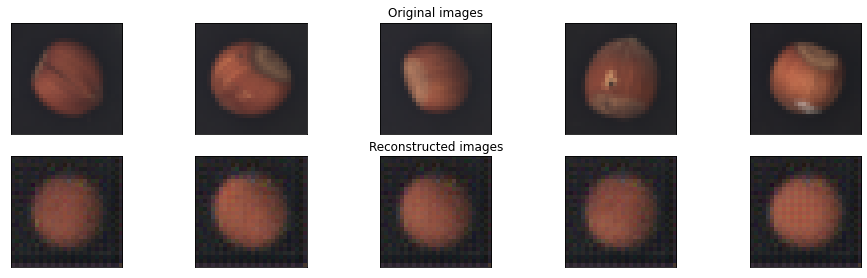

	 partial train loss (single batch): 0.001450
	 partial train loss (single batch): 0.001395
	 partial train loss (single batch): 0.001518
	 partial train loss (single batch): 0.001364
	 partial train loss (single batch): 0.001494
	 partial train loss (single batch): 0.001356
	 partial train loss (single batch): 0.001432
	 partial train loss (single batch): 0.001382
	 partial train loss (single batch): 0.001383
	 partial train loss (single batch): 0.001403
	 partial train loss (single batch): 0.001349
	 partial train loss (single batch): 0.001504
	 partial train loss (single batch): 0.001234

 EPOCH 65/80 	 train loss 0.0014047280419617891 	 val loss 0.0017806487157940865


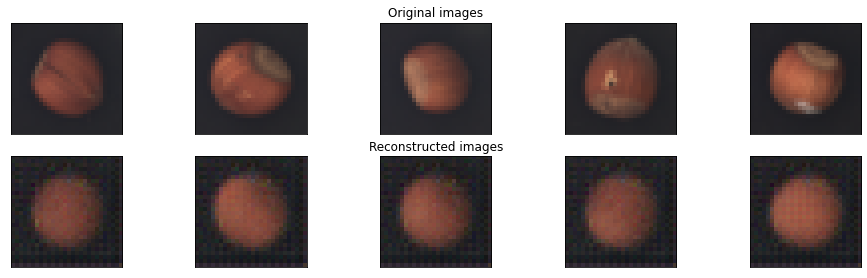

	 partial train loss (single batch): 0.001344
	 partial train loss (single batch): 0.001465
	 partial train loss (single batch): 0.001426
	 partial train loss (single batch): 0.001417
	 partial train loss (single batch): 0.001337
	 partial train loss (single batch): 0.001402
	 partial train loss (single batch): 0.001456
	 partial train loss (single batch): 0.001510
	 partial train loss (single batch): 0.001336
	 partial train loss (single batch): 0.001400
	 partial train loss (single batch): 0.001459
	 partial train loss (single batch): 0.001317
	 partial train loss (single batch): 0.001817

 EPOCH 66/80 	 train loss 0.001437509898096323 	 val loss 0.0017978171817958355


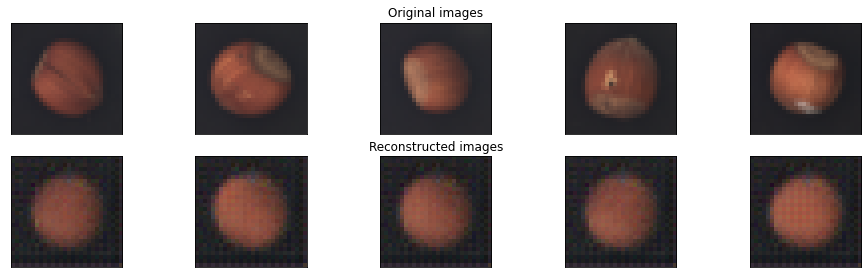

	 partial train loss (single batch): 0.001398
	 partial train loss (single batch): 0.001552
	 partial train loss (single batch): 0.001436
	 partial train loss (single batch): 0.001380
	 partial train loss (single batch): 0.001511
	 partial train loss (single batch): 0.001382
	 partial train loss (single batch): 0.001379
	 partial train loss (single batch): 0.001568
	 partial train loss (single batch): 0.001377
	 partial train loss (single batch): 0.001384
	 partial train loss (single batch): 0.001300
	 partial train loss (single batch): 0.001508
	 partial train loss (single batch): 0.001247

 EPOCH 67/80 	 train loss 0.0014170289505273104 	 val loss 0.001784621737897396


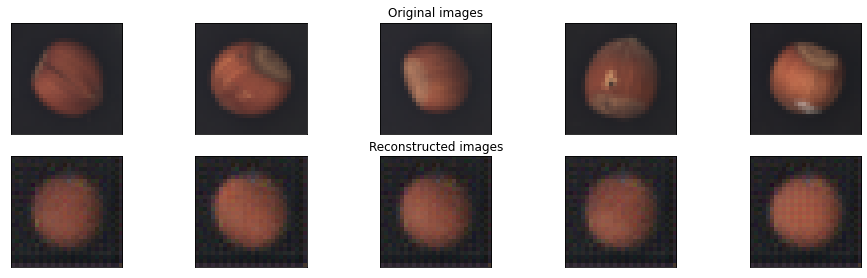

	 partial train loss (single batch): 0.001513
	 partial train loss (single batch): 0.001447
	 partial train loss (single batch): 0.001349
	 partial train loss (single batch): 0.001387
	 partial train loss (single batch): 0.001380
	 partial train loss (single batch): 0.001354
	 partial train loss (single batch): 0.001284
	 partial train loss (single batch): 0.001270
	 partial train loss (single batch): 0.001402
	 partial train loss (single batch): 0.001396
	 partial train loss (single batch): 0.001389
	 partial train loss (single batch): 0.001294
	 partial train loss (single batch): 0.001520

 EPOCH 68/80 	 train loss 0.0013834816636517644 	 val loss 0.0017262648325413465


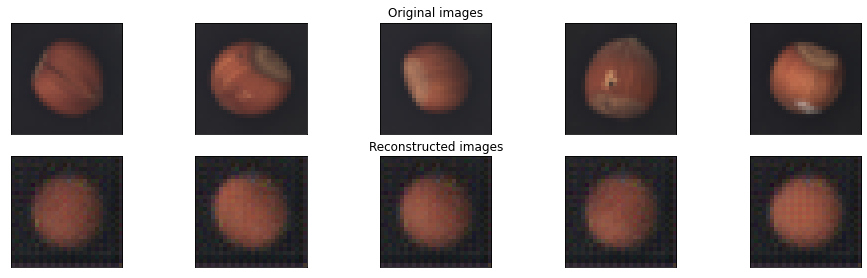

	 partial train loss (single batch): 0.001382
	 partial train loss (single batch): 0.001420
	 partial train loss (single batch): 0.001411
	 partial train loss (single batch): 0.001349
	 partial train loss (single batch): 0.001350
	 partial train loss (single batch): 0.001453
	 partial train loss (single batch): 0.001369
	 partial train loss (single batch): 0.001263
	 partial train loss (single batch): 0.001364
	 partial train loss (single batch): 0.001362
	 partial train loss (single batch): 0.001466
	 partial train loss (single batch): 0.001321
	 partial train loss (single batch): 0.001234

 EPOCH 69/80 	 train loss 0.001364759635180235 	 val loss 0.0017014113254845142


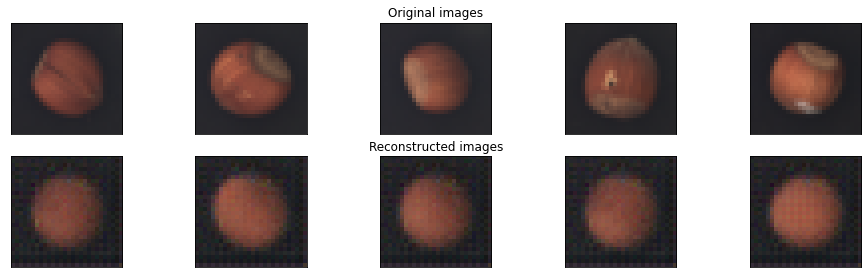

	 partial train loss (single batch): 0.001305
	 partial train loss (single batch): 0.001381
	 partial train loss (single batch): 0.001490
	 partial train loss (single batch): 0.001333
	 partial train loss (single batch): 0.001330
	 partial train loss (single batch): 0.001437
	 partial train loss (single batch): 0.001252
	 partial train loss (single batch): 0.001328
	 partial train loss (single batch): 0.001429
	 partial train loss (single batch): 0.001285
	 partial train loss (single batch): 0.001488
	 partial train loss (single batch): 0.001219
	 partial train loss (single batch): 0.001212

 EPOCH 70/80 	 train loss 0.0013452928978949785 	 val loss 0.0017440618248656392


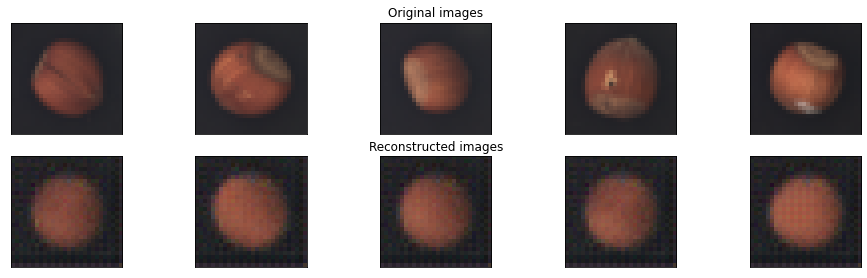

	 partial train loss (single batch): 0.001361
	 partial train loss (single batch): 0.001318
	 partial train loss (single batch): 0.001311
	 partial train loss (single batch): 0.001302
	 partial train loss (single batch): 0.001309
	 partial train loss (single batch): 0.001319
	 partial train loss (single batch): 0.001297
	 partial train loss (single batch): 0.001320
	 partial train loss (single batch): 0.001332
	 partial train loss (single batch): 0.001357
	 partial train loss (single batch): 0.001526
	 partial train loss (single batch): 0.001243
	 partial train loss (single batch): 0.001323

 EPOCH 71/80 	 train loss 0.0013321799924597144 	 val loss 0.001682193367742002


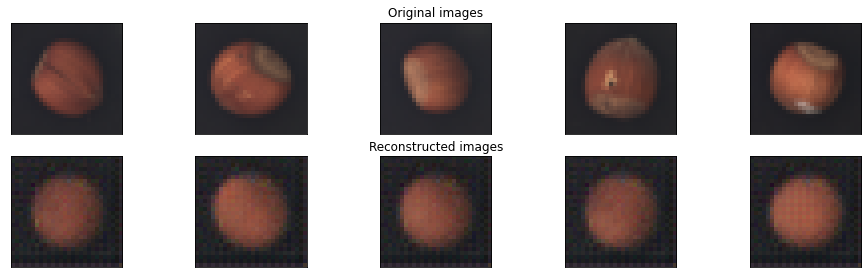

	 partial train loss (single batch): 0.001250
	 partial train loss (single batch): 0.001245
	 partial train loss (single batch): 0.001315
	 partial train loss (single batch): 0.001311
	 partial train loss (single batch): 0.001377
	 partial train loss (single batch): 0.001336
	 partial train loss (single batch): 0.001402
	 partial train loss (single batch): 0.001416
	 partial train loss (single batch): 0.001333
	 partial train loss (single batch): 0.001376
	 partial train loss (single batch): 0.001245
	 partial train loss (single batch): 0.001294
	 partial train loss (single batch): 0.001255

 EPOCH 72/80 	 train loss 0.0013196596410125494 	 val loss 0.0016824386548250914


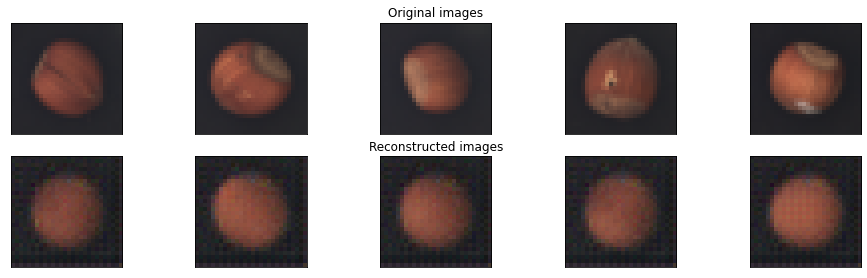

	 partial train loss (single batch): 0.001480
	 partial train loss (single batch): 0.001307
	 partial train loss (single batch): 0.001470
	 partial train loss (single batch): 0.001274
	 partial train loss (single batch): 0.001280
	 partial train loss (single batch): 0.001252
	 partial train loss (single batch): 0.001184
	 partial train loss (single batch): 0.001344
	 partial train loss (single batch): 0.001291
	 partial train loss (single batch): 0.001292
	 partial train loss (single batch): 0.001276
	 partial train loss (single batch): 0.001421
	 partial train loss (single batch): 0.001356

 EPOCH 73/80 	 train loss 0.0013251530472189188 	 val loss 0.0016990434378385544


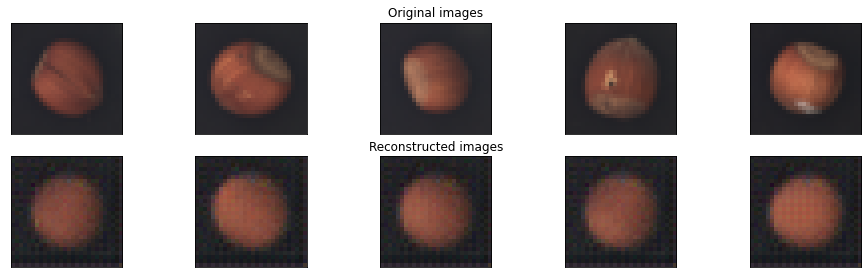

	 partial train loss (single batch): 0.001250
	 partial train loss (single batch): 0.001298
	 partial train loss (single batch): 0.001470
	 partial train loss (single batch): 0.001222
	 partial train loss (single batch): 0.001360
	 partial train loss (single batch): 0.001287
	 partial train loss (single batch): 0.001496
	 partial train loss (single batch): 0.001205
	 partial train loss (single batch): 0.001327
	 partial train loss (single batch): 0.001394
	 partial train loss (single batch): 0.001301
	 partial train loss (single batch): 0.001220
	 partial train loss (single batch): 0.001341

 EPOCH 74/80 	 train loss 0.0013208645395934582 	 val loss 0.0016885347431525588


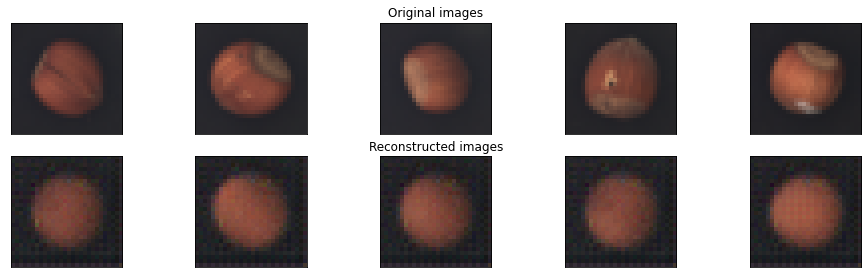

	 partial train loss (single batch): 0.001244
	 partial train loss (single batch): 0.001294
	 partial train loss (single batch): 0.001317
	 partial train loss (single batch): 0.001343
	 partial train loss (single batch): 0.001182
	 partial train loss (single batch): 0.001350
	 partial train loss (single batch): 0.001360
	 partial train loss (single batch): 0.001294
	 partial train loss (single batch): 0.001196
	 partial train loss (single batch): 0.001445
	 partial train loss (single batch): 0.001327
	 partial train loss (single batch): 0.001316
	 partial train loss (single batch): 0.001253

 EPOCH 75/80 	 train loss 0.0013015170115977526 	 val loss 0.0017376566538587213


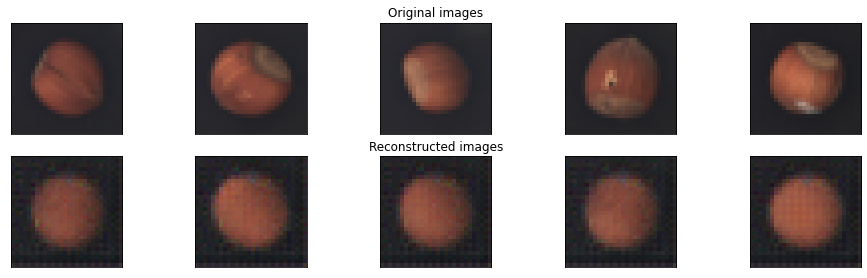

	 partial train loss (single batch): 0.001375
	 partial train loss (single batch): 0.001324
	 partial train loss (single batch): 0.001198
	 partial train loss (single batch): 0.001439
	 partial train loss (single batch): 0.001280
	 partial train loss (single batch): 0.001190
	 partial train loss (single batch): 0.001331
	 partial train loss (single batch): 0.001221
	 partial train loss (single batch): 0.001358
	 partial train loss (single batch): 0.001279
	 partial train loss (single batch): 0.001187
	 partial train loss (single batch): 0.001329
	 partial train loss (single batch): 0.001197

 EPOCH 76/80 	 train loss 0.001285172183997929 	 val loss 0.0016535113099962473


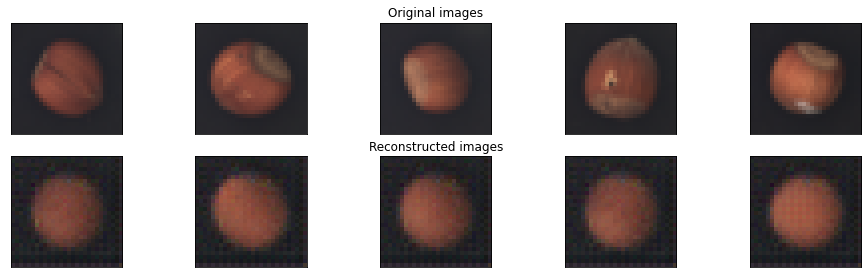

	 partial train loss (single batch): 0.001241
	 partial train loss (single batch): 0.001238
	 partial train loss (single batch): 0.001144
	 partial train loss (single batch): 0.001220
	 partial train loss (single batch): 0.001269
	 partial train loss (single batch): 0.001126
	 partial train loss (single batch): 0.001386
	 partial train loss (single batch): 0.001311
	 partial train loss (single batch): 0.001222
	 partial train loss (single batch): 0.001603
	 partial train loss (single batch): 0.001392
	 partial train loss (single batch): 0.001303
	 partial train loss (single batch): 0.001428

 EPOCH 77/80 	 train loss 0.0012985188513994217 	 val loss 0.001714612590149045


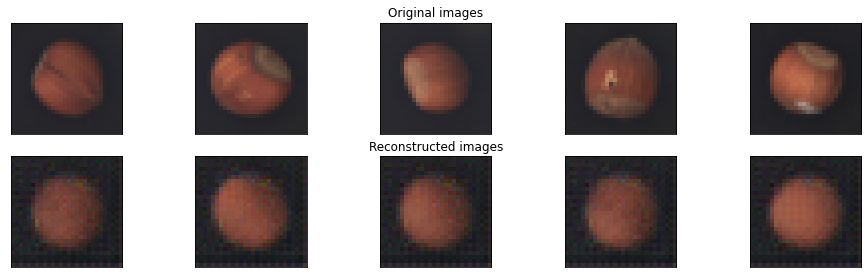

	 partial train loss (single batch): 0.001313
	 partial train loss (single batch): 0.001290
	 partial train loss (single batch): 0.001406
	 partial train loss (single batch): 0.001273
	 partial train loss (single batch): 0.001336
	 partial train loss (single batch): 0.001288
	 partial train loss (single batch): 0.001287
	 partial train loss (single batch): 0.001290
	 partial train loss (single batch): 0.001259
	 partial train loss (single batch): 0.001324
	 partial train loss (single batch): 0.001324
	 partial train loss (single batch): 0.001173
	 partial train loss (single batch): 0.001337

 EPOCH 78/80 	 train loss 0.0013000920880585909 	 val loss 0.0021128866355866194


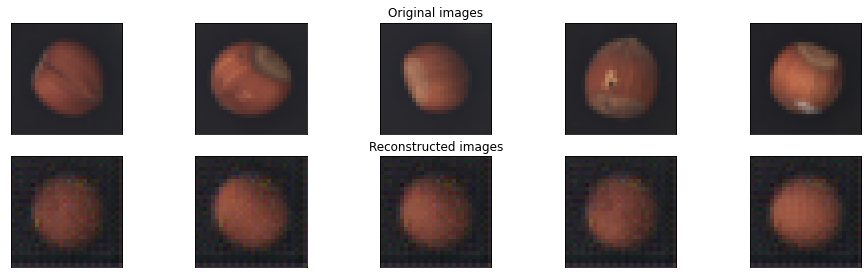

	 partial train loss (single batch): 0.001257
	 partial train loss (single batch): 0.001419
	 partial train loss (single batch): 0.001275
	 partial train loss (single batch): 0.001361
	 partial train loss (single batch): 0.001365
	 partial train loss (single batch): 0.001304
	 partial train loss (single batch): 0.001388
	 partial train loss (single batch): 0.001442
	 partial train loss (single batch): 0.001231
	 partial train loss (single batch): 0.001466
	 partial train loss (single batch): 0.001239
	 partial train loss (single batch): 0.001190
	 partial train loss (single batch): 0.001257

 EPOCH 79/80 	 train loss 0.001322670141234994 	 val loss 0.0016540049109607935


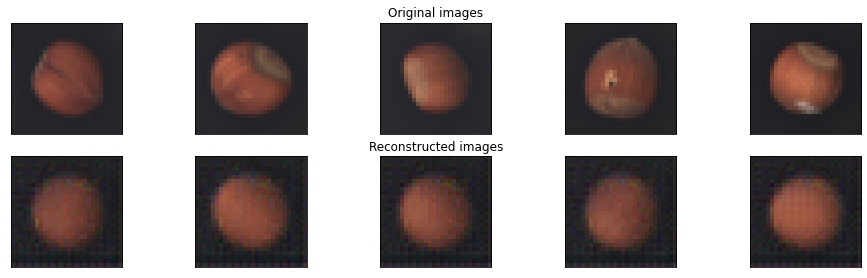

	 partial train loss (single batch): 0.001171
	 partial train loss (single batch): 0.001184
	 partial train loss (single batch): 0.001297
	 partial train loss (single batch): 0.001318
	 partial train loss (single batch): 0.001195
	 partial train loss (single batch): 0.001426
	 partial train loss (single batch): 0.001405
	 partial train loss (single batch): 0.001220
	 partial train loss (single batch): 0.001260
	 partial train loss (single batch): 0.001222
	 partial train loss (single batch): 0.001118
	 partial train loss (single batch): 0.001203
	 partial train loss (single batch): 0.001327

 EPOCH 80/80 	 train loss 0.0012572741834446788 	 val loss 0.00165322155226022


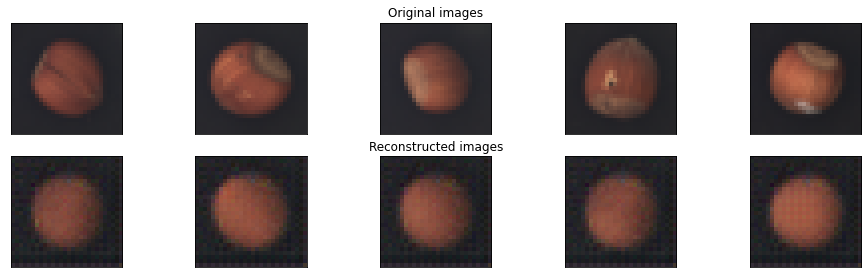

In [15]:
num_epochs = 80
# Unified loss dictionary
h_diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   # Calculate training loss
   h_train_loss = train_epoch(encoder,decoder,device,
   hazelnut_train_loader,loss_fn,optim)
   # Calculate validation loss
   h_val_loss = test_epoch(encoder,decoder,device,hazelnut_test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,h_train_loss,h_val_loss))
   h_diz_loss['train_loss'].append(h_train_loss)
   h_diz_loss['val_loss'].append(h_val_loss)
   plot_ae_outputs(encoder,decoder,hazelnut_vis_test_loader,n=5)

### Hazelnut losses

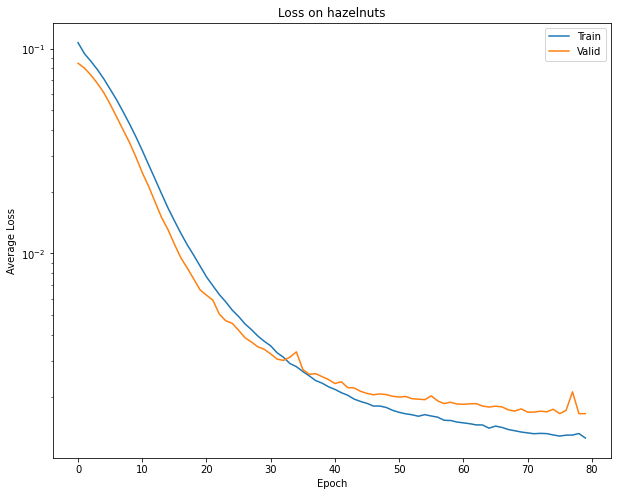

In [16]:
# Plot losses for hazelnuts
plt.figure(figsize=(10,8))
plt.semilogy(h_diz_loss['train_loss'], label='Train')
plt.semilogy(h_diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
plt.title('Loss on hazelnuts')
plt.show()

### Hazelnut test

In [17]:
# final loss on the test dataset
test_epoch(encoder,decoder,device,hazelnut_test_loader,loss_fn).item()

0.00165322155226022

### Hazelnut experimental evaluation

In [18]:
# the error threshold for the prediction
FPR = 0.5
threshold = compute_threshold(encoder, decoder, hazelnut_test_loader, fpr=FPR)
threshold

0.08230301186442338

Calculate the accuracy of the anomaly prediction on the test dataset, and visualize some samples

In [19]:
from sklearn.metrics import classification_report

preds, labels = evaluation(encoder, decoder, hazelnut_test_loader, threshold)
accuracy = sum([prediction == label for (prediction, label) in zip(preds, labels)]) / len(preds)
print("Accuracy:", accuracy)

print(classification_report(labels, preds, target_names=["False (Good)", "True (Anomaly)"]))

Accuracy: 0.6704545454545454
                precision    recall  f1-score   support

  False (Good)       0.54      0.76      0.63        33
True (Anomaly)       0.81      0.62      0.70        55

      accuracy                           0.67        88
     macro avg       0.68      0.69      0.67        88
  weighted avg       0.71      0.67      0.68        88



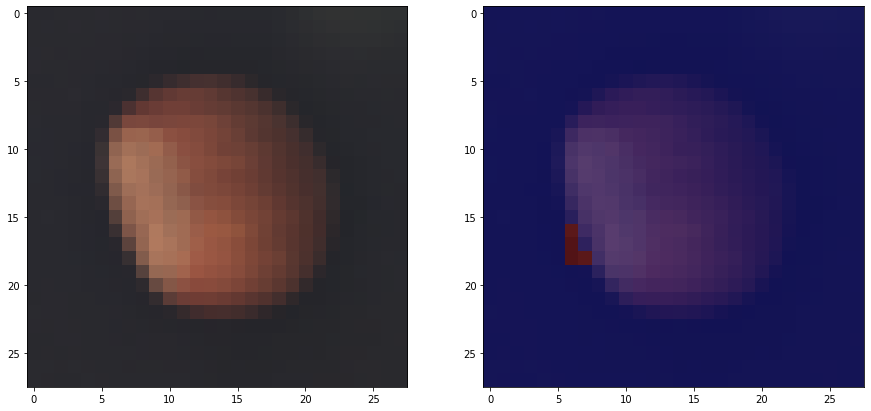

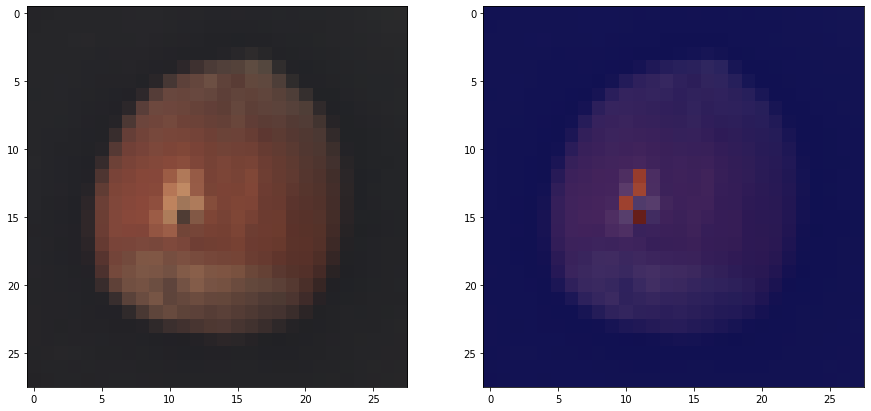

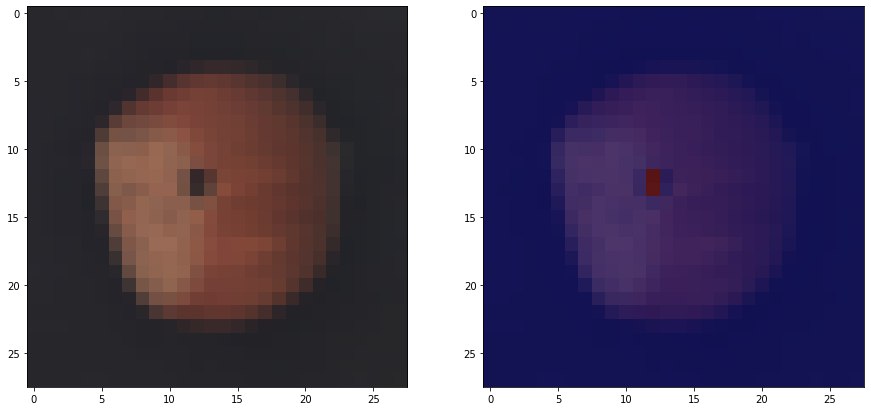

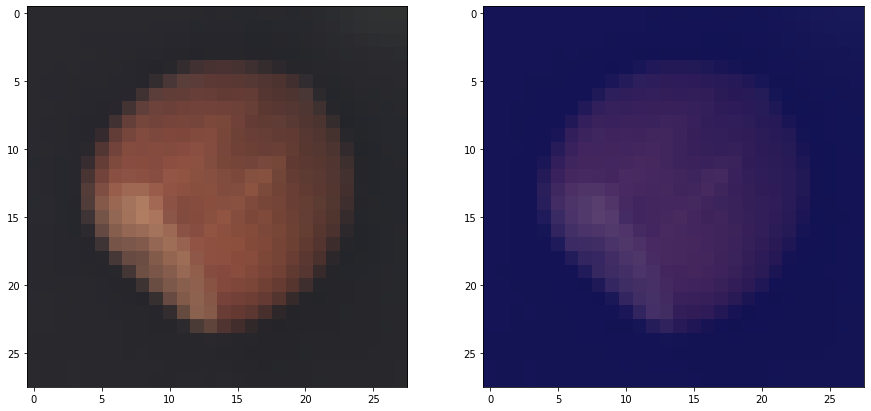

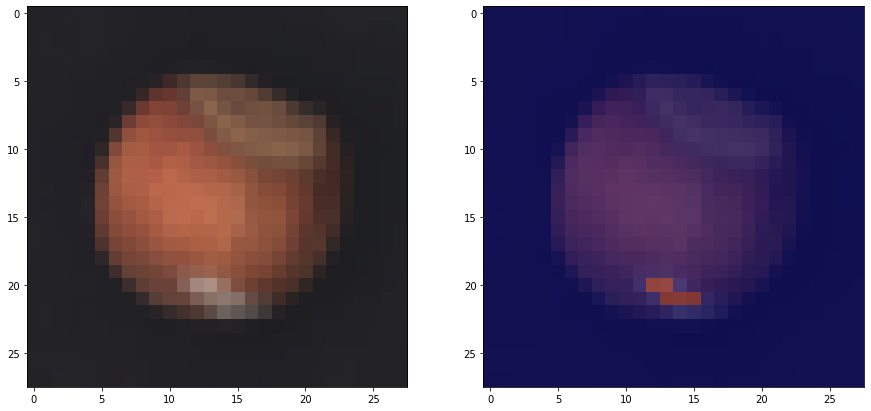

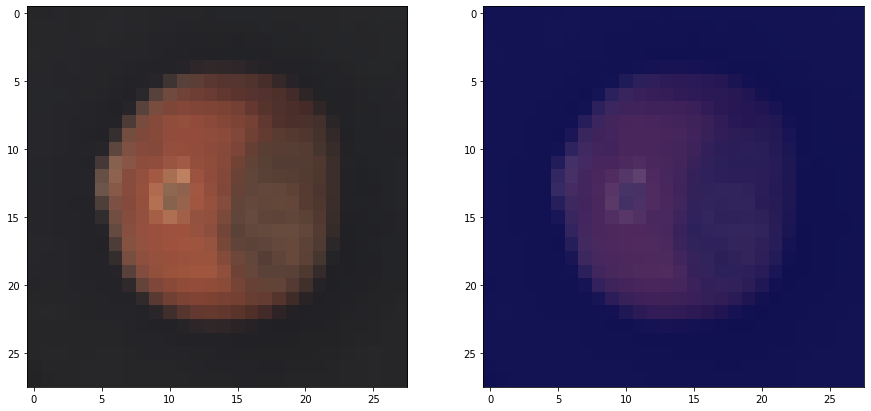

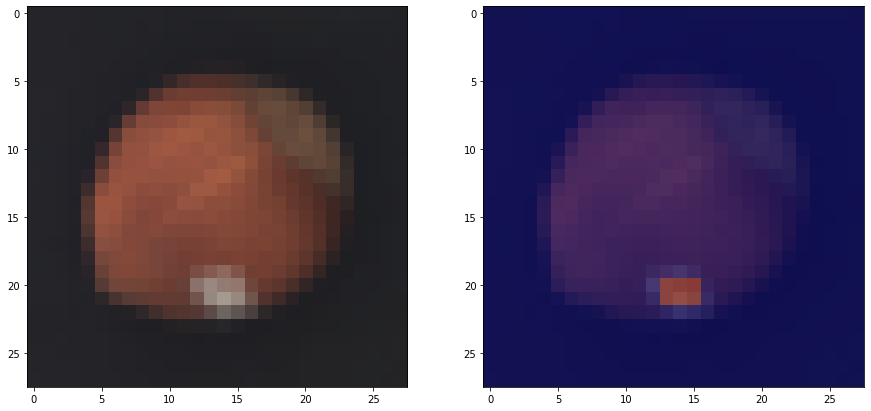

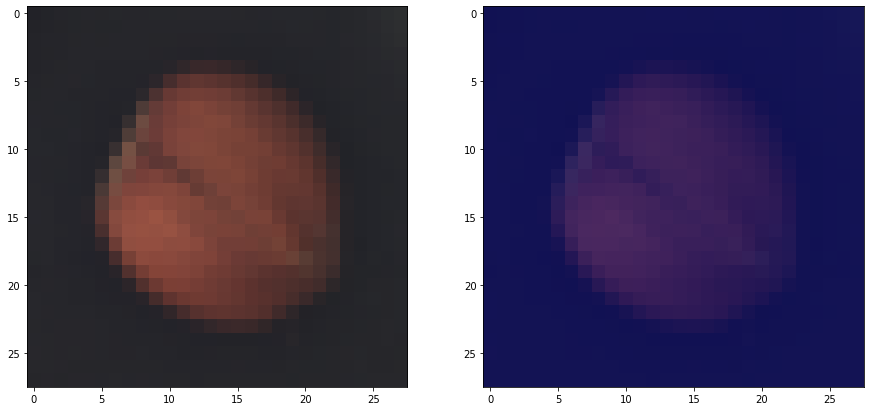

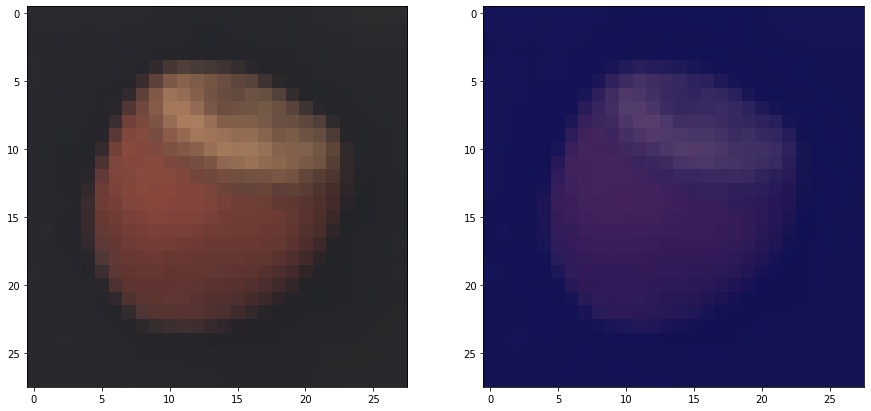

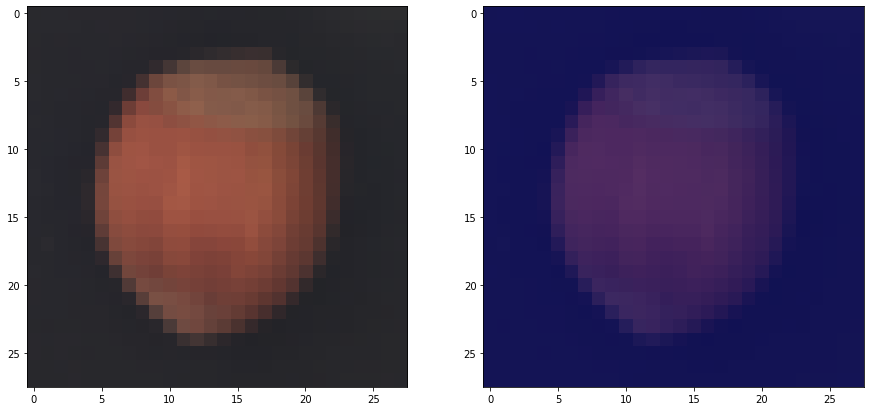

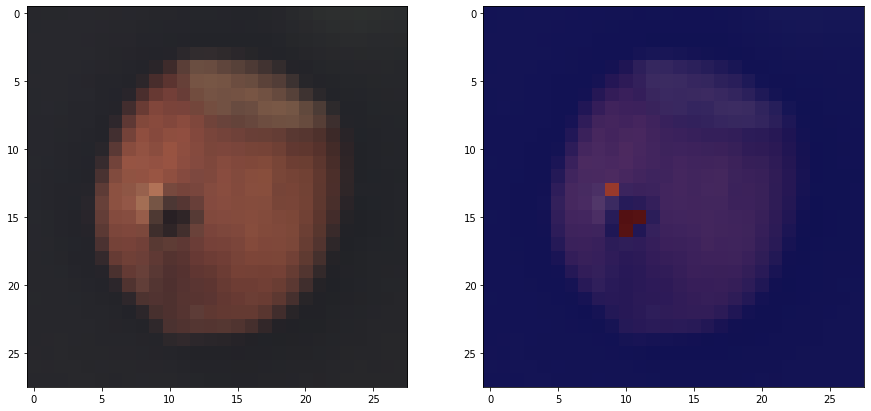

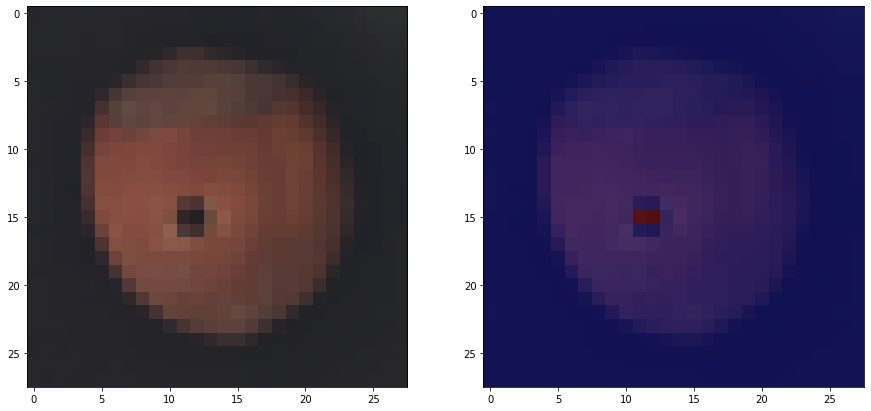

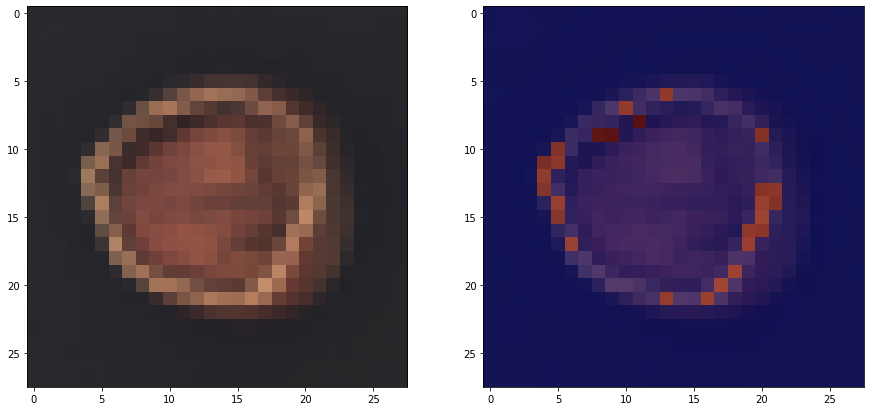

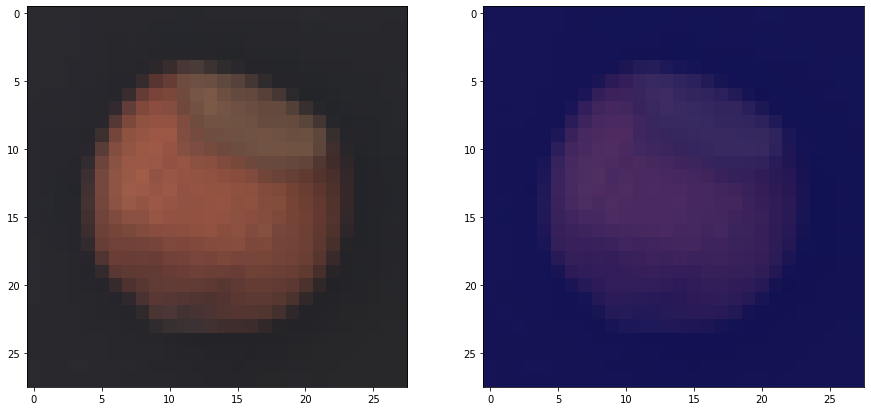

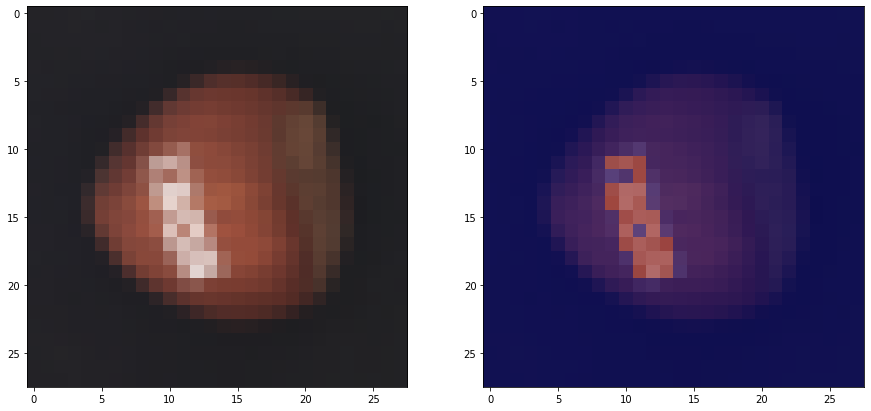

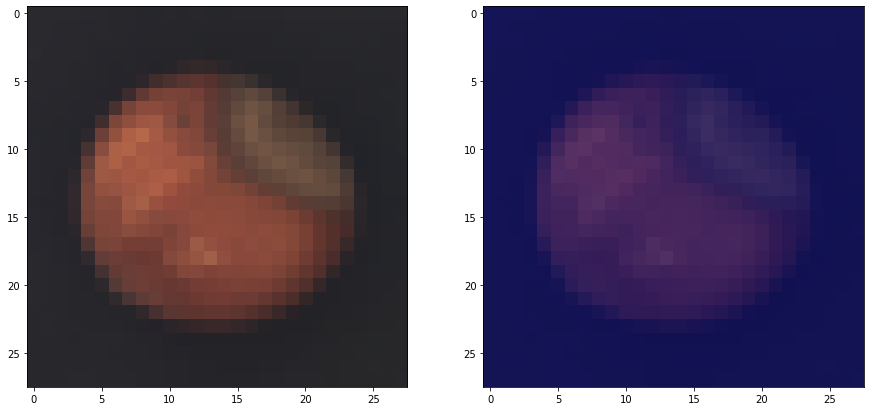

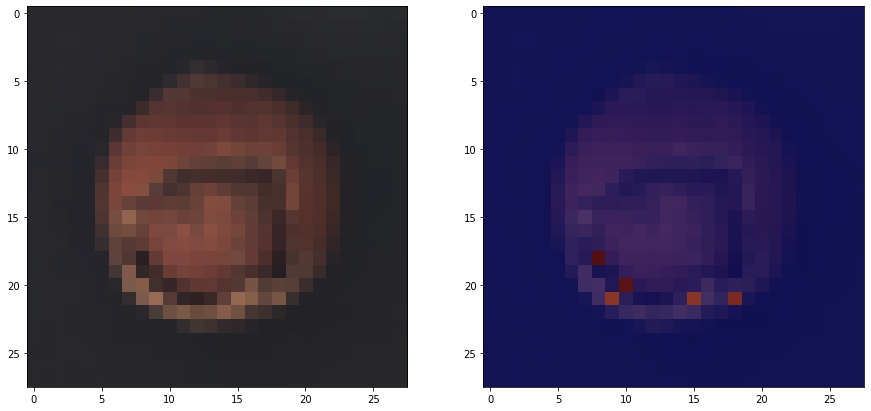

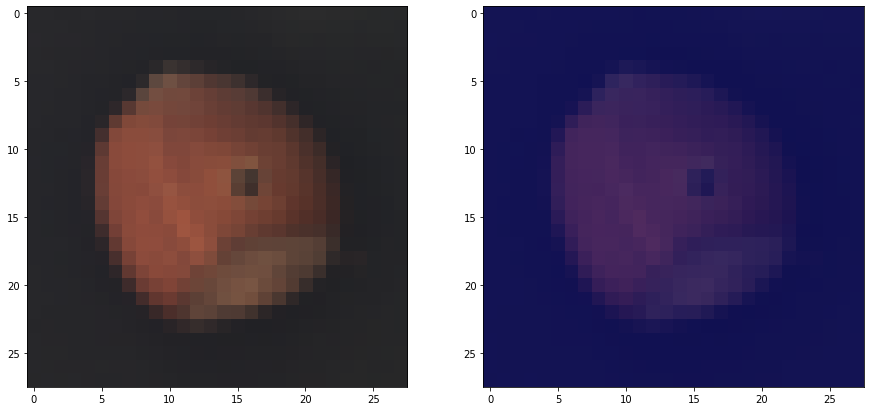

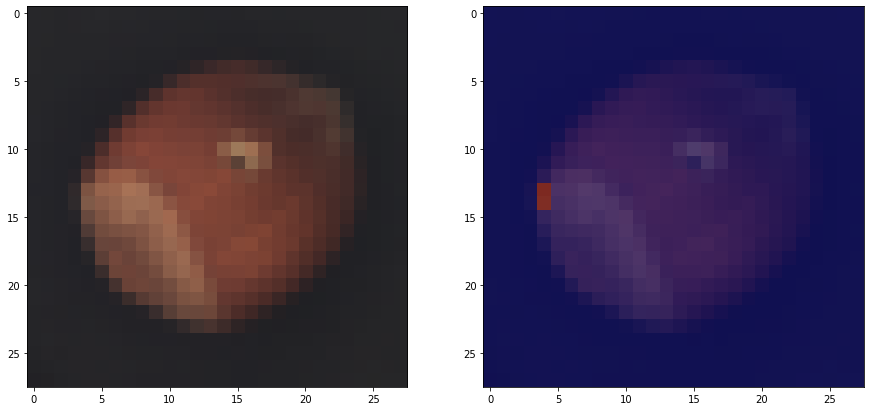

In [20]:
experimental_evaluation(encoder, decoder, hazelnut_test_dataset, threshold, n=20)